In [1]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN-AD")

In [2]:
from pyTVDN import TVDNDetect
from pathlib import Path
from scipy.io import loadmat
import numpy as np
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import os
import scipy.stats as ss
from scipy import signal
from tqdm import tqdm
import pickle
import seaborn as sns
import numbers
import scipy
import pandas as pd
%matplotlib inline

In [3]:
regionNamesRaw  ="""
ctx-lh-bankssts
ctx-lh-caudalanteriorcingulate
ctx-lh-caudalmiddlefrontal
ctx-lh-cuneus
ctx-lh-entorhinal
ctx-lh-frontalpole
ctx-lh-fusiform
ctx-lh-inferiorparietal
ctx-lh-inferiortemporal
ctx-lh-insula
ctx-lh-isthmuscingulate
ctx-lh-lateraloccipital
ctx-lh-lateralorbitofrontal
ctx-lh-lingual
ctx-lh-medialorbitofrontal
ctx-lh-middletemporal
ctx-lh-paracentral
ctx-lh-parahippocampal
ctx-lh-parsopercularis
ctx-lh-parsorbitalis
ctx-lh-parstriangularis
ctx-lh-pericalcarine
ctx-lh-postcentral
ctx-lh-posteriorcingulate
ctx-lh-precentral
ctx-lh-precuneus
ctx-lh-rostralanteriorcingulate
ctx-lh-rostralmiddlefrontal
ctx-lh-superiorfrontal
ctx-lh-superiorparietal
ctx-lh-superiortemporal
ctx-lh-supramarginal
ctx-lh-temporalpole
ctx-lh-transversetemporal
ctx-rh-bankssts
ctx-rh-caudalanteriorcingulate
ctx-rh-caudalmiddlefrontal
ctx-rh-cuneus
ctx-rh-entorhinal
ctx-rh-frontalpole
ctx-rh-fusiform
ctx-rh-inferiorparietal
ctx-rh-inferiortemporal
ctx-rh-insula
ctx-rh-isthmuscingulate
ctx-rh-lateraloccipital
ctx-rh-lateralorbitofrontal
ctx-rh-lingual
ctx-rh-medialorbitofrontal
ctx-rh-middletemporal
ctx-rh-paracentral
ctx-rh-parahippocampal
ctx-rh-parsopercularis
ctx-rh-parsorbitalis
ctx-rh-parstriangularis
ctx-rh-pericalcarine
ctx-rh-postcentral
ctx-rh-posteriorcingulate
ctx-rh-precentral
ctx-rh-precuneus
ctx-rh-rostralanteriorcingulate
ctx-rh-rostralmiddlefrontal
ctx-rh-superiorfrontal
ctx-rh-superiorparietal
ctx-rh-superiortemporal
ctx-rh-supramarginal
ctx-rh-temporalpole
ctx-rh-transversetemporal
"""
regionNames = [i.strip()[4].title() + i.strip()[6:].title() for i in regionNamesRaw.split("\n") if len(i.strip())>0]

In [4]:
os.chdir("/home/huaqingj/MyResearch/TVDN-AD/")
resDir = Path("./results")
dataDir = Path("./data")

## Load features

### Load data

In [5]:
# ecpts
fil = list(resDir.glob("AD*_ecpts.pkl"))[0]
with open(fil, "rb") as f:
    ecptssAD = pickle.load(f)
fil = list(resDir.glob("Ctrl*_ecpts.pkl"))[0]
with open(fil, "rb") as f:
    ecptssCtrl = pickle.load(f)

In [6]:
# Eigvals
fil = list(resDir.glob("AD*_eigVals.pkl"))[0]
with open(fil, "rb") as f:
    eigValsAD = pickle.load(f)
fil = list(resDir.glob("Ctrl*_eigVals.pkl"))[0]
with open(fil, "rb") as f:
    eigValsCtrl = pickle.load(f)

In [7]:
fil = list(resDir.glob("AD*_eigVecs.pkl"))[0]
with open(fil, "rb") as f:
    eigVecsAD = pickle.load(f)
fil = list(resDir.glob("Ctrl*_eigVecs.pkl"))[0]
with open(fil, "rb") as f:
    eigVecsCtrl = pickle.load(f)

In [8]:
### The canonical networks
def minmax(x):
    num = x - np.min(x)
    den = np.max(x) - np.min(x)
    return num/den

fcR = pd.read_csv('./OtherFils/DK_dic68.csv').set_index('Unnamed: 0')
rowNames = list(fcR.index)
colNames = np.array(fcR.columns)

fcRarr = np.array(fcR)

# minmax 
fcRarrMM = np.zeros_like(fcRarr)
for i, fcRar in enumerate(fcRarr):
    # lh = minmax(fcRar[:34])
    # rh = minmax(fcRar[34:])
    # fcRarrMM[i, :34] = lh
    # fcRarrMM[i, 34:] = rh
    fcRarrMM[i, :] = minmax(fcRar)

### The basic data transformation 

In [9]:
# Dwell times in second
freq = 120
dwellsAD = [np.diff(np.concatenate([[0], ecpts, [7200]])/freq) for ecpts in ecptssAD]
dwellsCtrl = [np.diff(np.concatenate([[0], ecpts, [7200]])/freq) for ecpts in ecptssCtrl]

In [10]:
ecptss = ecptssAD
dwells = dwellsAD
eigVals = eigValsAD
eigVecs = eigVecsAD

fsAll = []
for i in range(len(ecptss)):
    fs = edict()
    dwell = dwells[i]
    fs.dwell = dwell 
    fs.ncpts = len(ecptss[i])
    fs.meanDwell = np.mean(dwell)
    fs.maxDwell = np.max(dwell)
    fs.minDwell = np.min(dwell)
    
    eigVal = eigVals[i]
    
    idx = np.argmax(dwell)
    if fs.ncpts >=1:
        idx2 = np.where((-dwell).argsort().argsort()==1)[0][0]
    
    maxEigVal = eigVal[idx]
    fs.maxEigVal = maxEigVal[np.argmax(np.abs(maxEigVal))]
    fs.maxEigValMode = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))])
    fs.maxEigValReal = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))].real)
    fs.maxEigValImag = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))].imag)
    
    
    tmp = maxEigVal.copy()
    tmp[np.abs(maxEigVal) == np.max(np.abs(maxEigVal))] = 0
    fs.max2EigVal = tmp[np.argmax(np.abs(tmp))]
    fs.max2EigValMode = np.abs(tmp[np.argmax(np.abs(tmp))])
    fs.max2EigValReal = np.abs(tmp[np.argmax(np.abs(tmp))].real)
    fs.max2EigValImag = np.abs(tmp[np.argmax(np.abs(tmp))].imag)
    
    fs.maxwU = np.abs(np.matmul(eigVecs[i], maxEigVal))
    fs.wUAll = np.abs(np.matmul(eigVecs[i], np.array(eigVal).T).real)
    fs.wUAllMM = (fs.wUAll - fs.wUAll.min(axis=0))/(fs.wUAll.max(axis=0)-fs.wUAll.min(axis=0))
    fs.wUAllMMmean = fs.wUAllMM.mean(axis=1)
    fs.wUsumAll = np.abs(np.matmul(eigVecs[i], np.array(eigVal).T).real).sum(axis=1)
    fs.wUmeanAll = np.abs(np.matmul(eigVecs[i], np.array(eigVal).T).real).mean(axis=1)
    fs.maxwUraw = np.matmul(eigVecs[i], maxEigVal).real
    fs.maxwUnorm = np.linalg.norm(fs.maxwU)
    
    fs.wUcorrsAll = []
    for jx in range(fs.wUAll.shape[1]):
        curwU = fs.wUAll[:, jx]
        curwUMM = np.zeros_like(curwU)
        # curwUMM[:34] = minmax(curwU[:34])
        # curwUMM[34:] = minmax(curwU[34:])
        curwUMM[:] = minmax(curwU[:])
        curwUcorrs = []
        for ix in range(fcRarrMM.shape[0]):
            fcRarrMMcur = fcRarrMM[ix, :]
            curwUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], curwUMM)[0])
        fs.wUcorrsAll.append(curwUcorrs)
    
    wUmeanMM = np.zeros_like(fs.wUmeanAll)
    # wUmeanMM[:34] = minmax(fs.wUmeanAll[:34])
    # wUmeanMM[34:] = minmax(fs.wUmeanAll[34:])
    wUmeanMM[:] = minmax(fs.wUmeanAll[:])
    fs.wUmeancorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.wUmeancorrs.append(ss.pearsonr(fcRarrMM[ix, :], wUmeanMM)[0])
    
    maxwUMM = np.zeros_like(fs.maxwU)
    #maxwUMM[:34] = minmax(fs.maxwU[:34])
    #maxwUMM[34:] = minmax(fs.maxwU[34:])
    maxwUMM[:] = minmax(fs.maxwU[:])
    fs.maxwUcorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.maxwUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], maxwUMM)[0])
        
    if fs.ncpts >=1:
        fs.maxwU2 = np.abs(np.matmul(eigVecs[i], eigVal[idx2]))
        fs.maxwU2norm = np.linalg.norm(fs.maxwU2)
    else:
        fs.maxwU2 = np.zeros(fs.maxwU.shape)
        fs.maxwU2norm = 0
    
    fs.maxU = eigVecs[i][:, np.argmax(np.abs(maxEigVal))]
    fs.maxUnorm = np.linalg.norm(fs.maxU)
    fs.maxUMode = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))])
    fs.maxUReal = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))].real)
    fs.maxUImag = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))].imag)
    maxUMM = np.zeros_like(fs.maxUMode)
    #maxUMM[:34] = minmax(fs.maxUMode[:34])
    #maxUMM[34:] = minmax(fs.maxUMode[34:])
    maxUMM[:] = minmax(fs.maxUMode[:])
    fs.maxUcorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.maxUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], maxUMM)[0])
    
    fs.r  = len(maxEigVal)
    
    fsAll.append(fs)
    
fsAD = fsAll    

In [11]:
ecptss = ecptssCtrl
dwells = dwellsCtrl
eigVals = eigValsCtrl
eigVecs = eigVecsCtrl

fsAll = []
for i in range(len(ecptss)):
    fs = edict()
    dwell = dwells[i]
    fs.dwell = dwell 
    fs.ncpts = len(ecptss[i])
    fs.meanDwell = np.mean(dwell)
    fs.maxDwell = np.max(dwell)
    fs.minDwell = np.min(dwell)
    
    eigVal = eigVals[i]
    
    idx = np.argmax(dwell)
    if fs.ncpts >=1:
        idx2 = np.where((-dwell).argsort().argsort()==1)[0][0]
    
    maxEigVal = eigVal[idx]
    fs.maxEigVal = maxEigVal[np.argmax(np.abs(maxEigVal))]
    fs.maxEigValMode = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))])
    fs.maxEigValReal = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))].real)
    fs.maxEigValImag = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))].imag)
    
    
    tmp = maxEigVal.copy()
    tmp[np.abs(maxEigVal) == np.max(np.abs(maxEigVal))] = 0
    fs.max2EigVal = tmp[np.argmax(np.abs(tmp))]
    fs.max2EigValMode = np.abs(tmp[np.argmax(np.abs(tmp))])
    fs.max2EigValReal = np.abs(tmp[np.argmax(np.abs(tmp))].real)
    fs.max2EigValImag = np.abs(tmp[np.argmax(np.abs(tmp))].imag)
    
    fs.maxwU = np.abs(np.matmul(eigVecs[i], maxEigVal))
    fs.wUAll = np.abs(np.matmul(eigVecs[i], np.array(eigVal).T).real)
    fs.wUAllMM = (fs.wUAll - fs.wUAll.min(axis=0))/(fs.wUAll.max(axis=0)-fs.wUAll.min(axis=0))
    fs.wUAllMMmean = fs.wUAllMM.mean(axis=1)
    fs.wUsumAll = np.abs(np.matmul(eigVecs[i], np.array(eigVal).T).real).sum(axis=1)
    fs.wUmeanAll = np.abs(np.matmul(eigVecs[i], np.array(eigVal).T).real).mean(axis=1)
    fs.maxwUraw = np.matmul(eigVecs[i], maxEigVal).real
    fs.maxwUnorm = np.linalg.norm(fs.maxwU)
    
    fs.wUcorrsAll = []
    for jx in range(fs.wUAll.shape[1]):
        curwU = fs.wUAll[:, jx]
        curwUMM = np.zeros_like(curwU)
        # curwUMM[:34] = minmax(curwU[:34])
        # curwUMM[34:] = minmax(curwU[34:])
        curwUMM[:] = minmax(curwU[:])
        curwUcorrs = []
        for ix in range(fcRarrMM.shape[0]):
            fcRarrMMcur = fcRarrMM[ix, :]
            curwUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], curwUMM)[0])
        fs.wUcorrsAll.append(curwUcorrs)
    
    wUmeanMM = np.zeros_like(fs.wUmeanAll)
    # wUmeanMM[:34] = minmax(fs.wUmeanAll[:34])
    # wUmeanMM[34:] = minmax(fs.wUmeanAll[34:])
    wUmeanMM[:] = minmax(fs.wUmeanAll[:])
    fs.wUmeancorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.wUmeancorrs.append(ss.pearsonr(fcRarrMM[ix, :], wUmeanMM)[0])
    
    maxwUMM = np.zeros_like(fs.maxwU)
    #maxwUMM[:34] = minmax(fs.maxwU[:34])
    #maxwUMM[34:] = minmax(fs.maxwU[34:])
    maxwUMM[:] = minmax(fs.maxwU[:])
    fs.maxwUcorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.maxwUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], maxwUMM)[0])
        
    if fs.ncpts >=1:
        fs.maxwU2 = np.abs(np.matmul(eigVecs[i], eigVal[idx2]))
        fs.maxwU2norm = np.linalg.norm(fs.maxwU2)
    else:
        fs.maxwU2 = np.zeros(fs.maxwU.shape)
        fs.maxwU2norm = 0
    
    fs.maxU = eigVecs[i][:, np.argmax(np.abs(maxEigVal))]
    fs.maxUnorm = np.linalg.norm(fs.maxU)
    fs.maxUMode = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))])
    fs.maxUReal = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))].real)
    fs.maxUImag = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))].imag)
    maxUMM = np.zeros_like(fs.maxUMode)
    #maxUMM[:34] = minmax(fs.maxUMode[:34])
    #maxUMM[34:] = minmax(fs.maxUMode[34:])
    maxUMM[:] = minmax(fs.maxUMode[:])
    fs.maxUcorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.maxUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], maxUMM)[0])
    
    fs.r  = len(maxEigVal)
    
    fsAll.append(fs)
    
fsCtrl = fsAll    

### Save the feature for brain plot

In [12]:
def U2BrainVec(wU):
    emVec = np.zeros_like(DKtmplate, dtype=np.float64)
    for idx in range(1, 69):
        emVec[DKtmplate==idx] = wU[idx-1]
    return emVec

def reorderU(wU):
    wUreorder = np.zeros_like(wU, dtype=np.float64)
    wUreorder[0::2] = wU[:34]
    wUreorder[1::2] = wU[34:]
    return wUreorder

In [13]:
# This function is to discretize the vec
def discretVec(Vec, ps=[0, 0.25, 0.5, 0.75, 1]):
    qs = np.quantile(Vec, ps)
    disVec = Vec 
    for ix in range(len(qs)-1):
        low = qs[ix]
        up = qs[ix+1]
        idxVec= np.bitwise_and(Vec >= low, Vec <up)
        disVec[idxVec] = np.mean(Vec[idxVec])
    return disVec

In [14]:
with open("./OtherFils/BNVtemplate_DK68.txt", "r") as tf:
    DKtmplateRaw = tf.readlines()
DKtmplate = np.array([int(x.strip()) for x in DKtmplateRaw])

In [15]:
# mean of  wUmean
fName = "wUmeanAll"
mFAD = np.array([fs[fName] for fs in fsAD]).mean(axis=0)
mFCtrl = np.array([fs[fName] for fs in fsCtrl]).mean(axis=0)
mFAD = minmax(mFAD)
mFCtrl = minmax(mFCtrl)
outAD = U2BrainVec(reorderU(mFAD))
outCtrl = U2BrainVec(reorderU(mFCtrl))
np.savetxt("./brainPlotFils/wUmeanAD.txt", outAD)
np.savetxt("./brainPlotFils/wUmeanCtrl.txt", outCtrl)
pd.DataFrame({"Name": regionNames, "Vec": mFAD}).to_csv("./brainPlotFils/wUmeanAD.csv", index=False)
pd.DataFrame({"Name": regionNames, "Vec": mFCtrl}).to_csv("./brainPlotFils/wUmeanCtrl.csv", index=False)

#### We do not need these code now

In [665]:
nDis = 8
fName = "wUmeanAll"
mFAD = np.array([fs[fName] for fs in fsAD]).mean(axis=0)
mFCtrl = np.array([fs[fName] for fs in fsCtrl]).mean(axis=0)
disMFAD = discretVec(mFAD, np.linspace(0, 1, nDis+1))
disMFCtrl = discretVec(mFCtrl, np.linspace(0, 1, nDis+1))
mFAD = minmax(disMFAD)
mFCtrl = minmax(disMFCtrl)
outAD = U2BrainVec(reorderU(mFAD))
outCtrl = U2BrainVec(reorderU(mFCtrl))
np.savetxt(f"./brainPlotFils/wUmeanAD_{nDis}.txt", outAD)
np.savetxt(f"./brainPlotFils/wUmeanCtrl_{nDis}.txt", outCtrl)
pd.DataFrame({"Name": regionNames, "Vec": mFAD}).to_csv(f"./brainPlotFils/wUmeanAD_{nDis}.csv", index=False)
pd.DataFrame({"Name": regionNames, "Vec": mFCtrl}).to_csv(f"./brainPlotFils/wUmeanCtrl_{nDis}.csv", index=False)

In [17]:
# mean of  wUsum
fName = "wUsumAll"
mFAD = np.array([fs[fName] for fs in fsAD]).mean(axis=0)
mFCtrl = np.array([fs[fName] for fs in fsCtrl]).mean(axis=0)
mFAD = minmax(mFAD)
mFCtrl = minmax(mFCtrl)
outAD = U2BrainVec(reorderU(mFAD))
outCtrl = U2BrainVec(reorderU(mFCtrl))
np.savetxt("./brainPlotFils/wUsumAD.txt", outAD)
np.savetxt("./brainPlotFils/wUsumCtrl.txt", outCtrl)

In [18]:
# mean of  wU1
fName = "maxwU"
mFAD = np.array([fs[fName] for fs in fsAD]).mean(axis=0)
mFCtrl = np.array([fs[fName] for fs in fsCtrl]).mean(axis=0)
mFAD = minmax(mFAD)
mFCtrl = minmax(mFCtrl)
outAD = U2BrainVec(reorderU(mFAD))
outCtrl = U2BrainVec(reorderU(mFCtrl))
np.savetxt("./brainPlotFils/wU1AD.txt", outAD)
np.savetxt("./brainPlotFils/wU1Ctrl.txt", outCtrl)

## Basic analysis

In [149]:
from prettytable import PrettyTable as pTB

### Some basic plots

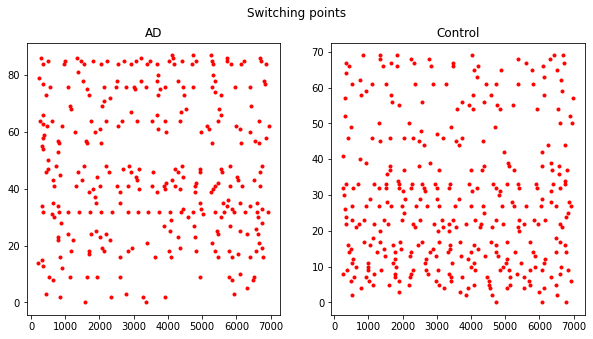

In [138]:
plt.figure(figsize=[10, 5])
plt.suptitle("Switching points")
plt.subplot(121)
for idx, ecpts in enumerate(ecptssAD):
    plt.plot(ecpts, [idx]*len(ecpts), ".r")
plt.title("AD")

plt.subplot(122)
for idx, ecpts in enumerate(ecptssCtrl):
    plt.plot(ecpts, [idx]*len(ecpts), ".r")
plt.title("Control")
plt.savefig("./plots/switching_pts.jpg", bbox_inches='tight')

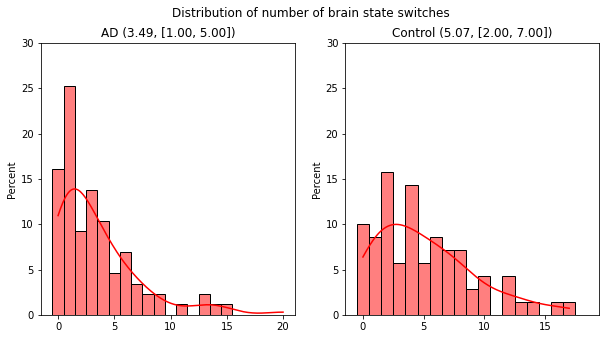

In [139]:
nchgsAD = [len(ecpts) for ecpts in ecptssAD]
nchgsCtrl = [len(ecpts) for ecpts in ecptssCtrl]
plt.figure(figsize=[10, 5])
plt.suptitle("Distribution of number of brain state switches")
plt.subplot(121)
plt.title(f"AD ({np.mean(nchgsAD):.2f}, [{np.quantile(nchgsAD, 0.25):.2f}, {np.quantile(nchgsAD, 0.75):.2f}])")
sns.histplot(nchgsAD, stat="percent", bins=np.array(list(range(0, 20)))-0.5, kde=1, color="red")
plt.xlabel("")
plt.ylim([0, 30])

plt.subplot(122)
plt.title(f"Control ({np.mean(nchgsCtrl):.2f}, [{np.quantile(nchgsCtrl, 0.25):.2f}, {np.quantile(nchgsCtrl, 0.75):.2f}])")
sns.histplot(nchgsCtrl, stat="percent", bins=np.array(list(range(0, 20)))-0.5, kde=1, color="red")
plt.ylim([0, 30])
plt.xlabel("")
plt.savefig("./plots/dist_switching_pts.jpg", bbox_inches='tight')

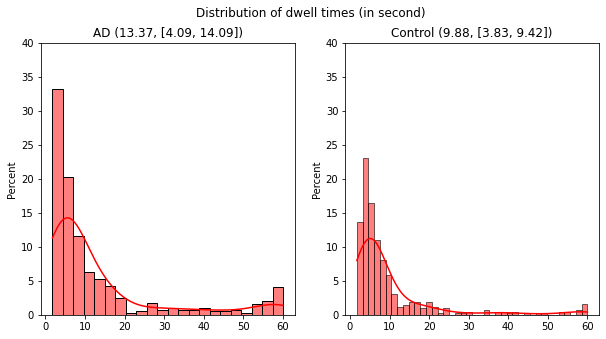

In [145]:
dwellADAll = np.concatenate([fs.dwell for fs in fsAD])
dwellCtrlAll = np.concatenate([fs.dwell for fs in fsCtrl])

plt.figure(figsize=[10, 5])
plt.suptitle("Distribution of dwell times (in second)")
plt.subplot(121)
plt.title(f"AD ({np.mean(dwellADAll):.2f}, [{np.quantile(dwellADAll, 0.25):.2f}, {np.quantile(dwellADAll, 0.75):.2f}])")
sns.histplot(dwellADAll, stat="percent", kde=1, color="red")
plt.xlabel("")
plt.ylim([0, 40])

plt.subplot(122)
plt.title(f"Control ({np.mean(dwellCtrlAll):.2f}, [{np.quantile(dwellCtrlAll, 0.25):.2f}, {np.quantile(dwellCtrlAll, 0.75):.2f}])")
sns.histplot(dwellCtrlAll, stat="percent", kde=1, color="red")
plt.ylim([0, 40])
plt.xlabel("")
plt.savefig("./plots/dist_dwellTimes.jpg", bbox_inches='tight')

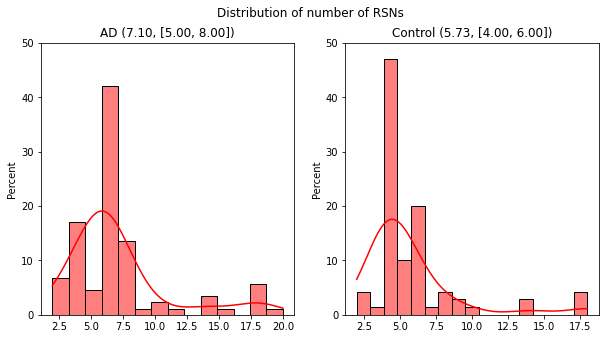

In [147]:
rksAD = [fs.r for fs in fsAD]
rksCtrl = [fs.r for fs in fsCtrl]
plt.figure(figsize=[10, 5])
plt.suptitle("Distribution of number of RSNs")
plt.subplot(121)
plt.title(f"AD ({np.mean(rksAD):.2f}, [{np.quantile(rksAD, 0.25):.2f}, {np.quantile(rksAD, 0.75):.2f}])")
sns.histplot(rksAD, stat="percent", kde=1, color="red")
plt.xlabel("")
plt.ylim([0, 50])

plt.subplot(122)
plt.title(f"Control ({np.mean(rksCtrl):.2f}, [{np.quantile(rksCtrl, 0.25):.2f}, {np.quantile(rksCtrl, 0.75):.2f}])")
sns.histplot(rksCtrl, stat="percent", kde=1, color="red")
plt.ylim([0, 50])
plt.xlabel("")

plt.savefig("./plots/dist_rks.jpg", bbox_inches='tight')

In [158]:
maxValsAD = []
for dwells, vals in zip(dwellsAD, eigValsAD):
    idx = np.argmax(dwells)
    val = vals[idx]
    maxValsAD.append(val[np.argmax(np.abs(val))])

maxValsCtrl = []
for dwells, vals in zip(dwellsCtrl, eigValsCtrl):
    idx = np.argmax(dwells)
    val = vals[idx]
    maxValsCtrl.append(val[np.argmax(np.abs(val))])

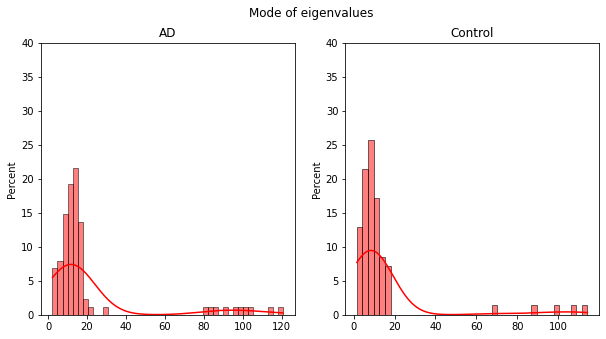

In [159]:
valModeAD = np.abs(maxValsAD)
valModeCtrl = np.abs(maxValsCtrl)
plt.figure(figsize=[10, 5])
plt.suptitle("Mode of eigenvalues")
plt.subplot(121)
plt.title("AD")
sns.histplot(valModeAD, stat="percent", kde=1, color="red")
plt.xlabel("")
plt.ylim([0, 40])

plt.subplot(122)
plt.title("Control")
sns.histplot(valModeCtrl, stat="percent", kde=1, color="red")
plt.ylim([0, 40])
plt.xlabel("")
plt.savefig("./plots/eigvalsMode.jpg", bbox_inches='tight')

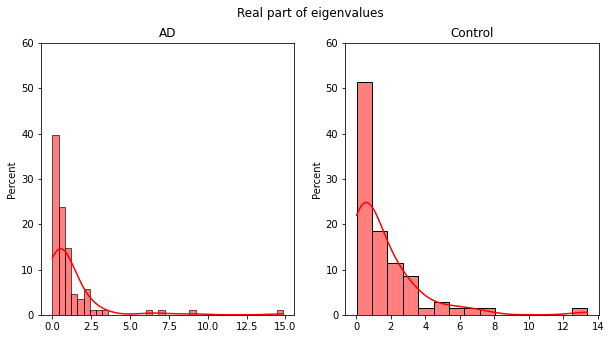

In [160]:
valRealAD = np.abs([val.real for val in maxValsAD])
valRealCtrl = np.abs([val.real for val in maxValsCtrl])
plt.figure(figsize=[10, 5])
plt.suptitle("Real part of eigenvalues")
plt.subplot(121)
plt.title("AD")
sns.histplot(valRealAD, stat="percent", kde=1, color="red")
plt.xlabel("")
plt.ylim([0, 60])

plt.subplot(122)
plt.title("Control")
sns.histplot(valRealCtrl, stat="percent", kde=1, color="red")
plt.ylim([0, 60])
plt.xlabel("")
plt.savefig("./plots/eigvalsReal.jpg", bbox_inches='tight')

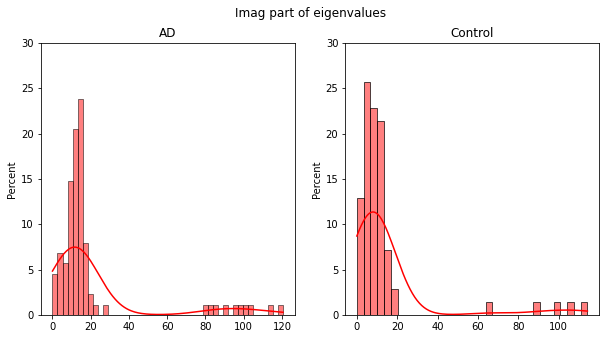

In [161]:
valImagAD = np.abs([val.imag for val in maxValsAD])
valImagCtrl = np.abs([val.imag for val in maxValsCtrl])
plt.figure(figsize=[10, 5])
plt.suptitle("Imag part of eigenvalues")
plt.subplot(121)
plt.title("AD")
sns.histplot(valImagAD, stat="percent", kde=1, color="red")
plt.xlabel("")
plt.ylim([0, 30])

plt.subplot(122)
plt.title("Control")
sns.histplot(valImagCtrl, stat="percent", kde=1, color="red")
plt.ylim([0, 30])
plt.xlabel("")
plt.savefig("./plots/eigvalsImag.jpg", bbox_inches='tight')

### Some tests

In [151]:
dwellsADM = [np.mean(v) for v in dwellsAD]
dwellsADV = [np.var(v) for v in dwellsAD]

dwellsCtrlM = [np.mean(v) for v in dwellsCtrl]
dwellsCtrlV = [np.var(v) for v in dwellsCtrl]

In [162]:
resTdwell = scipy.stats.ttest_ind(dwellADAll, dwellCtrlAll)
resTcpt = scipy.stats.ttest_ind(nchgsAD, nchgsCtrl)
resTdwM = scipy.stats.ttest_ind(dwellsADM, dwellsCtrlM)
resTdwV = scipy.stats.ttest_ind(dwellsADV, dwellsCtrlV)
resTmode = scipy.stats.ttest_ind(valModeAD, valModeCtrl)
resTReal = scipy.stats.ttest_ind(valRealAD, valRealCtrl)
resTImag = scipy.stats.ttest_ind(valImagAD, valImagCtrl)

resRSdwell = scipy.stats.ranksums(dwellADAll, dwellCtrlAll)
resRScpt = scipy.stats.ranksums(nchgsAD, nchgsCtrl)
resRSdwM = scipy.stats.ranksums(dwellsADM, dwellsCtrlM)
resRSdwV = scipy.stats.ranksums(dwellsADV, dwellsCtrlV)
resRSmode = scipy.stats.ranksums(valModeAD, valModeCtrl)
resRSReal = scipy.stats.ranksums(valRealAD, valRealCtrl)
resRSImag = scipy.stats.ranksums(valImagAD, valImagCtrl)

resKSdwell = scipy.stats.kstest(dwellADAll, dwellCtrlAll)
resKScpt = scipy.stats.kstest(nchgsAD, nchgsCtrl)
resKSdwM = scipy.stats.kstest(dwellsADM, dwellsCtrlM)
resKSdwV = scipy.stats.kstest(dwellsADV, dwellsCtrlV)
resKSmode = scipy.stats.kstest(valModeAD, valModeCtrl)
resKSReal = scipy.stats.kstest(valRealAD, valRealCtrl)
resKSImag = scipy.stats.kstest(valImagAD, valImagCtrl)

In [163]:
res = pTB()
res.field_names = [" ", "nCpt", "dwell", "dwell mean",  "dwell var", "EigVal Mode", "EigVal Real", "EigVal Imag"]
res.add_row(["T test", resTcpt.pvalue, resTdwell.pvalue, resTdwM.pvalue, resTdwV.pvalue, 
             resTmode.pvalue, resTReal.pvalue, resTImag.pvalue])
res.add_row(["RS test", resRScpt.pvalue, resRSdwell.pvalue, resRSdwM.pvalue, resRSdwV.pvalue,
             resRSmode.pvalue, resRSReal.pvalue, resRSImag.pvalue])
res.add_row(["KS test", resKScpt.pvalue, resKSdwell.pvalue, resKSdwM.pvalue, resKSdwV.pvalue, 
            resKSmode.pvalue, resKSReal.pvalue, resKSImag.pvalue])
res.float_format = ".4"
print(res)

+---------+--------+--------+------------+-----------+-------------+-------------+-------------+
|         |  nCpt  | dwell  | dwell mean | dwell var | EigVal Mode | EigVal Real | EigVal Imag |
+---------+--------+--------+------------+-----------+-------------+-------------+-------------+
|  T test | 0.0127 | 0.0003 |   0.0177   |   0.1067  |    0.1044   |    0.2263   |    0.0964   |
| RS test | 0.0032 | 0.0112 |   0.0029   |   0.2396  |    0.0000   |    0.2166   |    0.0000   |
| KS test | 0.0207 | 0.0020 |   0.0207   |   0.2052  |    0.0000   |    0.1103   |    0.0000   |
+---------+--------+--------+------------+-----------+-------------+-------------+-------------+


In [155]:
# mean of nCpts and Dwelltimes
resM = pTB()
resM.field_names = [" ", "nCpt", "dwell"]
resM.add_row(["AD", np.mean(nchgsAD), np.mean(dwellADAll)])
resM.add_row(["Ctrl", np.mean(nchgsCtrl), np.mean(dwellCtrlAll)])
resM.float_format = ".2"
print(resM)

+------+------+-------+
|      | nCpt | dwell |
+------+------+-------+
|  AD  | 3.49 | 13.37 |
| Ctrl | 5.07 |  9.88 |
+------+------+-------+


##  Distinguish between AD anc Ctrl

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import roc_auc_score, roc_curve

import matplotlib.cbook as cbook
import statsmodels.api as sm

from sklearn.cluster import KMeans, SpectralClustering
from scipy.stats import fisher_exact
from prettytable import PrettyTable as pTB
from sklearn.metrics import f1_score
from collections import defaultdict as ddict


from sklearn.cluster import SpectralClustering, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from scipy.stats import chi2_contingency
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

### Logistic under different features

In [21]:
penalty= "l2"
fsNameSet = [["r"], ["maxwU"], ["ncpts"],  ["wUsumAll"],  ["wUmeanAll"], 
             ["ncpts", "maxwU"],  ["ncpts", "wUsumAll"],  ["ncpts", "wUmeanAll"], 
             ["r", "maxwU"],  ["r", "wUsumAll"],  ["r", "wUmeanAll"], 
             ["r", "ncpts", "maxwU"], 
             ["r", "ncpts", "wUsumAll"],  
             ["r", "ncpts", "wUmeanAll"], 
             ["wUAllMMmean"],
             ["ncpts", "wUAllMMmean"], 
             ["r", "wUAllMMmean"],
             ["r", "ncpts", "wUAllMMmean"]
            ]
print("="*100)
print(f"The penalty is {penalty}.")
for fsName in fsNameSet:
    Ys = np.concatenate([np.ones(len(fsAD)), np.zeros(len(fsCtrl))])
    XsAD = []
    XsCtrl = []
    for fName in fsName:
        if isinstance(fsAD[0][fName], numbers.Number):
            cfAD = np.array([fs[fName] for fs in fsAD]).reshape(-1, 1)
            cfCtrl = np.array([fs[fName] for fs in fsCtrl]).reshape(-1, 1)
        else:
            cfAD = np.array([fs[fName] for fs in fsAD])
            cfCtrl = np.array([fs[fName] for fs in fsCtrl])
        
        XsAD.append(cfAD)
        XsCtrl.append(cfCtrl)
    XsAD = np.concatenate(XsAD, axis=1)
    XsCtrl = np.concatenate(XsCtrl, axis=1)
    Xs = np.concatenate([XsAD, XsCtrl], axis=0)
    stdXs = (Xs - Xs.mean(axis=0))/Xs.std(axis=0)
    
    Cs = [0.1, 0.2, 0.4, 0.8, 1, 1.6, 3.2, 6.4]
    aucCs = []
    for C in Cs:
        eProbs = []
        loo = LeaveOneOut()
        for trIdxs, testIdxs in loo.split(stdXs):
            clf = LogisticRegression(penalty=penalty, random_state=0, C=C)
            clf.fit(stdXs[trIdxs, :], Ys[trIdxs])
            eProbs.append(clf.predict_proba(stdXs[testIdxs, :]))
        eProbs = np.array(eProbs).squeeze()
        auc = roc_auc_score(Ys, eProbs[:, 1])
        fpr, tpr, thresholds = roc_curve(Ys, eProbs[:, 1], pos_label=1)
        aucCs.append(auc)
        
    optC = Cs[np.argmax(aucCs)]
    eProbs = []
    loo = LeaveOneOut()
    parass = []
    for trIdxs, testIdxs in loo.split(stdXs):
        clf = LogisticRegression(penalty=penalty, random_state=0, C=optC)
        clf.fit(stdXs[trIdxs, :], Ys[trIdxs])
        paras = np.concatenate([clf.intercept_, clf.coef_.reshape(-1)])
        parass.append(paras)
        eProbs.append(clf.predict_proba(stdXs[testIdxs, :]))
    eProbs = np.array(eProbs).squeeze()
    auc = roc_auc_score(Ys, eProbs[:, 1])
    fpr, tpr, thresholds = roc_curve(Ys, eProbs[:, 1], pos_label=1)
    parass = np.array(parass)
    
    nobs = stdXs.shape[0]
    Aucss = []
    for j in range(1000):
        testIdx = np.random.choice(nobs, int(nobs/5), False)
        trainIdx = np.delete(np.arange(nobs), testIdx)
        clf = LogisticRegression(penalty=penalty, random_state=0, C=optC)
        clf.fit(stdXs[trainIdx], Ys[trainIdx])
        curEprobs = clf.predict_proba(stdXs[testIdx, :])
        curAuc = roc_auc_score(Ys[testIdx], curEprobs[:, 1])
        Aucss.append(curAuc)
    mAUC = np.mean(Aucss)
    stdAUC = np.std(Aucss)
    print(f"Features are {fsName}.")
    print(f"The AUC under optimal C is {auc:.3f}.")
    print(f"The mean of AUC under 1000 repetitions is {mAUC:.3f} and the standard deviation is {stdAUC:.3f}.")
    print("-"*100)

The penalty is l2.
Features are ['r'].
The AUC under optimal C is 0.572.
The mean of AUC under 1000 repetitions is 0.659 and the standard deviation is 0.091.
----------------------------------------------------------------------------------------------------
Features are ['maxwU'].
The AUC under optimal C is 0.605.
The mean of AUC under 1000 repetitions is 0.623 and the standard deviation is 0.092.
----------------------------------------------------------------------------------------------------
Features are ['ncpts'].
The AUC under optimal C is 0.592.
The mean of AUC under 1000 repetitions is 0.638 and the standard deviation is 0.092.
----------------------------------------------------------------------------------------------------
Features are ['wUsumAll'].
The AUC under optimal C is 0.698.
The mean of AUC under 1000 repetitions is 0.704 and the standard deviation is 0.084.
----------------------------------------------------------------------------------------------------
Featur

### Choose one model under the Logistic

#### Fit the main  model

including

- LOO evalution

- CV 

- Plot the ROC

In [18]:
penalty = "l2"
Ys = np.concatenate([np.ones(len(fsAD)), np.zeros(len(fsCtrl))])
fsName = ["r", "ncpts", "wUmeanAll"]
XsAD = []
XsCtrl = []
for fName in fsName:
    if isinstance(fsAD[0][fName], numbers.Number):
        cfAD = np.array([fs[fName] for fs in fsAD]).reshape(-1, 1)
        cfCtrl = np.array([fs[fName] for fs in fsCtrl]).reshape(-1, 1)
    else:
        cfAD = np.array([fs[fName] for fs in fsAD])
        cfCtrl = np.array([fs[fName] for fs in fsCtrl])
    
    XsAD.append(cfAD)
    XsCtrl.append(cfCtrl)
XsAD = np.concatenate(XsAD, axis=1)
XsCtrl = np.concatenate(XsCtrl, axis=1)
Xs = np.concatenate([XsAD, XsCtrl], axis=0)
stdXs = (Xs - Xs.mean(axis=0))/Xs.std(axis=0)

# name prefix to save the results
preFix = "_".join(fsName) + f"_{penalty}"

Text(0, 0.5, 'AUC')

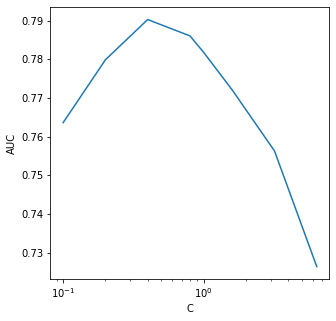

In [19]:
Cs = [0.1, 0.2, 0.4, 0.8, 1, 1.6, 3.2, 6.4]
aucCs = []
for C in Cs:
    eProbs = []
    loo = LeaveOneOut()
    for trIdxs, testIdxs in loo.split(stdXs):
        clf = LogisticRegression(penalty=penalty, random_state=0, C=C)
        clf.fit(stdXs[trIdxs, :], Ys[trIdxs])
        eProbs.append(clf.predict_proba(stdXs[testIdxs, :]))
    eProbs = np.array(eProbs).squeeze()
    auc = roc_auc_score(Ys, eProbs[:, 1])
    fpr, tpr, thresholds = roc_curve(Ys, eProbs[:, 1], pos_label=1)
    aucCs.append(auc)
    
plt.figure(figsize=[5, 5])
plt.plot(Cs, aucCs)
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("AUC")

In [20]:
optC = Cs[np.argmax(aucCs)]
eProbs = []
loo = LeaveOneOut()
parass = []
for trIdxs, testIdxs in loo.split(stdXs):
    #clf = GBC(n_estimators=50, random_state=0, max_depth=2, learning_rate=0.1)
    clf = LogisticRegression(penalty=penalty, random_state=0, C=optC)
    clf.fit(stdXs[trIdxs, :], Ys[trIdxs])
    paras = clf.coef_.reshape(-1)
    parass.append(paras)
    eProbs.append(clf.predict_proba(stdXs[testIdxs, :]))
eProbs = np.array(eProbs).squeeze()
auc = roc_auc_score(Ys, eProbs[:, 1])
fpr, tpr, thresholds = roc_curve(Ys, eProbs[:, 1], pos_label=1)
parass = np.array(parass)
print(auc)

0.7902597402597403


In [21]:
nobs = stdXs.shape[0]
Aucss = []
for j in range(1000):
    testIdx = np.random.choice(nobs, int(nobs/5), False)
    trainIdx = np.delete(np.arange(nobs), testIdx)
    clf = LogisticRegression(penalty=penalty, random_state=0, C=optC)
    clf.fit(stdXs[trainIdx], Ys[trainIdx])
    curEprobs = clf.predict_proba(stdXs[testIdx, :])
    curAuc = roc_auc_score(Ys[testIdx], curEprobs[:, 1])
    Aucss.append(curAuc)
mAUC = np.mean(Aucss)
stdAUC = np.std(Aucss)
print(f"The mean of AUC under 1000 repetitions is {mAUC:.3f} and the standard deviation is {stdAUC:.3f}.")

The mean of AUC under 1000 repetitions is 0.782 and the standard deviation is 0.082.


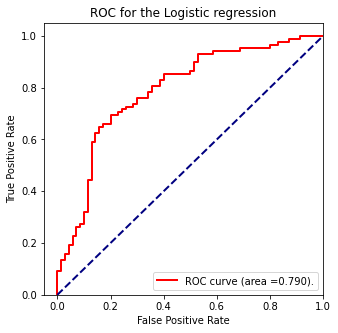

In [22]:
plt.figure(figsize=[5, 5])
plt.plot(fpr, tpr, label=f"ROC curve (area ={auc:.3f}).", lw=2, color="red")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for the Logistic regression")
plt.legend(loc="lower right")
plt.savefig(f"./plots/{preFix}_roc.jpg", bbox_inches='tight')

#### Select important features

##### LOO Confidence interval selection

Not good
(I do not use it)

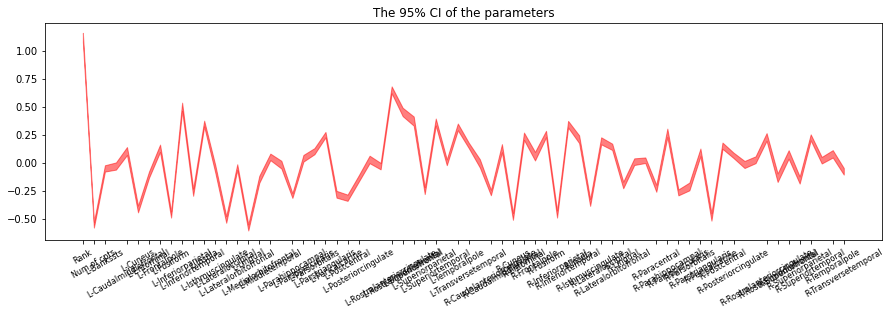

In [24]:
lows, ups = np.quantile(parass[:, :], [0.025, 0.975], axis=0)
#kpidxLOO = np.bitwise_and(lows !=0,  ups != 0)
kpidxLOO = np.bitwise_or(lows >0,  ups < 0)
kpidxLOOId = np.where(kpidxLOO)[0]

xlabs = np.concatenate([["Rank", "Num of cpts"], regionNames])
plt.figure(figsize=[15, 4])
plt.fill_between(list(range(len(lows))), lows, ups, color="red", alpha=.5)
plt.title("The 95% CI of the parameters")
_ = plt.xticks(kpidxLOOId, xlabs[kpidxLOOId], rotation=30, fontsize=8)
#plt.savefig(f"./plots/{preFix}_penaltySel.jpg", bbox_inches='tight')

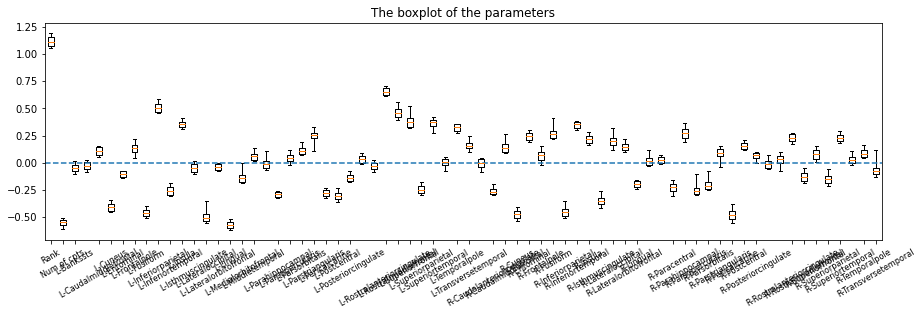

In [26]:
fig, ax = plt.subplots(1, 1, figsize=[15, 4])
stats = []
for idx, nam in enumerate(xlabs):
    stats.append(cbook.boxplot_stats(parass[:, idx], labels=[nam])[0])
    stats[idx]["q1"], stats[idx]["q3"] = np.percentile(parass[:, idx], [2.5, 97.5])
    stats[idx]["whishi"], stats[idx]["whislo"] = np.max(parass[:, idx]), np.min(parass[:, idx])
    stats[idx]["med"] = stats[idx]["mean"]
ax.bxp(stats, positions=range(len(lows)), showfliers=False)    
plt.axhline(y=0, ls="--")
plt.title("The boxplot of the parameters")
_ = plt.xticks(kpidxLOOId, xlabs[kpidxLOOId], rotation=30, fontsize=8)
#plt.savefig(f"./plots/{preFix}_penaltySel.jpg", bbox_inches='tight')

In [28]:
#md = sm.Logit(Ys, stdXs)
md = sm.Logit(Ys, sm.add_constant(stdXs[:, kpidxLOO])) # add intercept
mdres = md.fit()
print(mdres.summary())
print(xlabs[kpidxLOO][mdres.pvalues[1:]<0.05])
#print(xlabs[kpidx])

Optimization terminated successfully.
         Current function value: 0.218097
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  158
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                           59
Date:                Sat, 26 Feb 2022   Pseudo R-squ.:                  0.6824
Time:                        09:43:30   Log-Likelihood:                -34.459
converged:                       True   LL-Null:                       -108.49
Covariance Type:            nonrobust   LLR p-value:                 1.316e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3484      2.107      2.064      0.039       0.219       8.478
x1             4.1258      1

##### Bootstrap Confidence interval selection

I use Bootstrap to select finally as it has better results

In [23]:
np.random.seed(0)
repTime = 10000
parassBoot = []
for i in range(repTime):
    bootIdx = np.random.choice(len(Ys), len(Ys))
    YsBoot = Ys[bootIdx]
    stdXsBoot = stdXs[bootIdx]
    clf = LogisticRegression(penalty=penalty, random_state=0, C=optC)
    clf.fit(stdXsBoot, YsBoot)
    parasBoot = clf.coef_.reshape(-1)
    parassBoot.append(parasBoot)

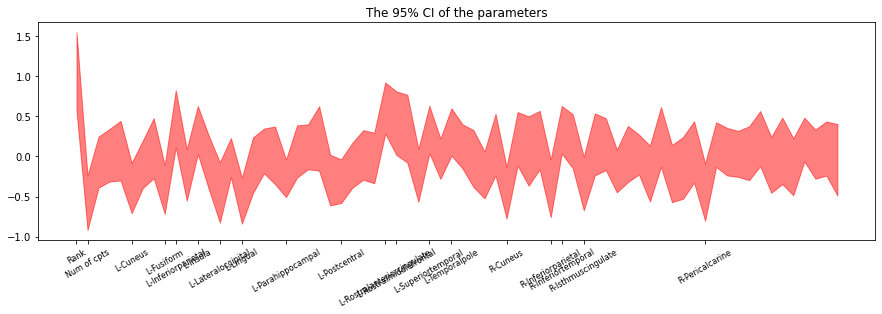

In [24]:
parassBoot = np.array(parassBoot)
lows, ups = np.quantile(parassBoot[:, :], [0.025, 0.975], axis=0)
kpidxBoot = np.bitwise_or(lows >0,  ups < 0)
kpidxIdBoot = np.where(kpidxBoot)[0]

xlabs = np.concatenate([["Rank", "Num of cpts"], regionNames])
plt.figure(figsize=[15, 4])
plt.fill_between(list(range(len(lows))), lows, ups, color="red", alpha=.5)
plt.title("The 95% CI of the parameters")
_ = plt.xticks(kpidxIdBoot, xlabs[kpidxIdBoot], rotation=30, fontsize=8)
plt.savefig(f"./plots/{preFix}_penaltySelBoot.jpg", bbox_inches='tight')

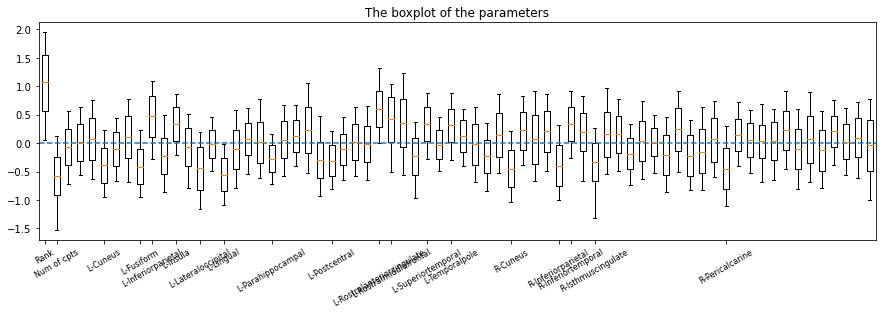

In [25]:
import matplotlib.cbook as cbook
fig, ax = plt.subplots(1, 1, figsize=[15, 4])
stats = []
for idx, nam in enumerate(xlabs):
    stats.append(cbook.boxplot_stats(parassBoot[:, idx], labels=[nam])[0])
    stats[idx]["q1"], stats[idx]["q3"] = np.percentile(parassBoot[:, idx], [2.5, 97.5])
    stats[idx]["whishi"], stats[idx]["whislo"] = np.max(parassBoot[:, idx]), np.min(parassBoot[:, idx])
    stats[idx]["med"] = stats[idx]["mean"]
ax.bxp(stats, positions=range(len(lows)), showfliers=False)    
plt.axhline(y=0, ls="--")
plt.title("The boxplot of the parameters")
_ = plt.xticks(kpidxIdBoot, xlabs[kpidxIdBoot], rotation=30, fontsize=8)
plt.savefig(f"./plots/{preFix}_penaltySelBoot.jpg", bbox_inches='tight')

#### Permutation test to obtain Pvs and sel parameter

In [26]:
np.random.seed(0)
repTime = 10000
parassPerm = []
for i in range(repTime):
    YsPerm = np.random.permutation(Ys)
    clf = LogisticRegression(penalty=penalty, random_state=0, C=optC)
    clf.fit(stdXs, YsPerm)
    parasPerm= clf.coef_.reshape(-1)
    parassPerm.append(parasPerm)
    
parassPerm = np.array(parassPerm)

clfFinal = LogisticRegression(penalty=penalty, random_state=0, C=optC)
clfFinal.fit(stdXs, Ys)
coefsFinal = clfFinal.coef_.reshape(-1)

# pvals = (np.abs(parassPerm) > np.abs(coefsFinal)).mean(axis=0)
pvals = np.array([(parassPerm > coefsFinal).mean(axis=0), (parassPerm < coefsFinal).mean(axis=0)]).min(axis=0)

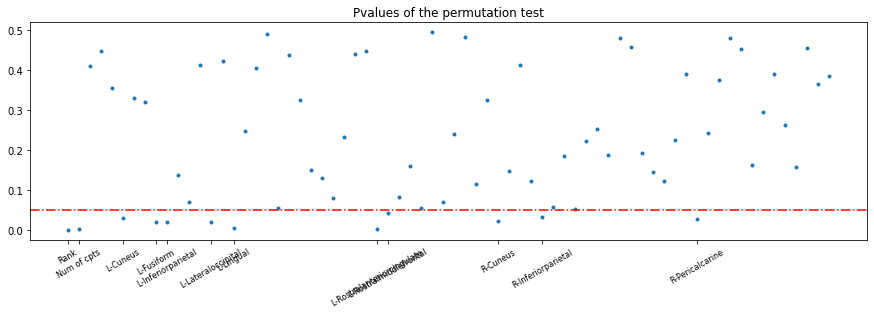

In [27]:
kpidxPerm = pvals < 0.05
kpidxIdPerm= np.where(kpidxPerm)[0]

plt.figure(figsize=[15, 4])
plt.plot(pvals, ".")
plt.axhline(y=0.05, color="red", ls="-.")
plt.title("Pvalues of the permutation test")
_ = plt.xticks(kpidxIdPerm, xlabs[kpidxIdPerm], rotation=30, fontsize=8)
plt.savefig(f"./plots/{preFix}_penaltySelPermPv.jpg", bbox_inches='tight')

#### The output table 

In [28]:
resDic = {
   "Feature" : xlabs[kpidxBoot],  
    "Parameters": coefsFinal[kpidxBoot],
    "Lower": lows[kpidxBoot],
    "Upper": ups[kpidxBoot],
    "Pvalues": pvals[kpidxBoot]
}
pd.set_option("display.precision", 3)
resDF = pd.DataFrame(resDic)
print(resDF)

                       Feature  Parameters  Lower  Upper  Pvalues
0                         Rank       1.112  0.570  1.550    0.000
1                  Num of cpts      -0.545 -0.916 -0.237    0.001
2                     L-Cuneus      -0.406 -0.707 -0.079    0.031
3                   L-Fusiform      -0.461 -0.715 -0.107    0.020
4           L-Inferiorparietal       0.508  0.114  0.826    0.021
5                     L-Insula       0.356  0.030  0.630    0.069
6           L-Lateraloccipital      -0.509 -0.825 -0.073    0.019
7                    L-Lingual      -0.575 -0.838 -0.264    0.005
8            L-Parahippocampal      -0.292 -0.507 -0.038    0.055
9                L-Postcentral      -0.307 -0.580 -0.035    0.081
10  L-Rostralanteriorcingulate       0.657  0.285  0.923    0.001
11      L-Rostralmiddlefrontal       0.459  0.021  0.813    0.041
12          L-Superiortemporal       0.373  0.040  0.633    0.054
13              L-Temporalpole       0.330  0.011  0.601    0.070
14        

#### Save data for brain under current model

In [919]:
# mean paras of LOO evaluation, do not need this
mParas = np.abs(parass.mean(axis=0)[2:])
outmParas = U2BrainVec(reorderU(minmax(mParas)))
np.savetxt(f"./brainPlotFils/{preFix}_meanParas.txt", outmParas)
pd.DataFrame({"Name": regionNames, "Vec": minmax(mParas)}).to_csv(f"./brainPlotFils/{preFix}_meanParas.csv", index=False)

In [920]:
# mean paras of Bootstrap, do not need this
mParasBoot = np.abs(parassBoot.mean(axis=0)[2:])
outmParasBoot = U2BrainVec(reorderU(minmax(mParasBoot)))
np.savetxt(f"./brainPlotFils/{preFix}_meanParasBoot.txt", outmParasBoot)
pd.DataFrame({"Name": regionNames, "Vec": minmax(mParasBoot)}).to_csv(f"./brainPlotFils/{preFix}_meanParasBoot.csv", index=False)

In [35]:
# final parameter
fParas = np.abs(coefsFinal[2:])
outfParas = U2BrainVec(reorderU(minmax(fParas)))
np.savetxt(f"./brainPlotFils/{preFix}_finalParas.txt", outfParas)
pd.DataFrame({"Name": regionNames, "Vec": minmax(fParas)}).to_csv(f"./brainPlotFils/{preFix}_finalParas.csv", index=False)

In [36]:
# The selected ROIs by after selection via bootstrap
selVec = (kpidxBoot[2:]).astype(np.int)
outSelVec = U2BrainVec(reorderU(selVec))
np.savetxt(f"./brainPlotFils/{preFix}_SelVecBoot.txt", outSelVec)
pd.DataFrame({"Name": regionNames, "Vec": selVec }).to_csv(f"./brainPlotFils/{preFix}_SelVecBoot.csv", index=False)

In [37]:
# The selected ROIs by after selection via pvalue
selVec = (kpidxPerm[2:]).astype(np.int)
outSelVec = U2BrainVec(reorderU(selVec))
np.savetxt(f"./brainPlotFils/{preFix}_SelVecPval.txt", outSelVec)
pd.DataFrame({"Name": regionNames, "Vec": selVec }).to_csv(f"./brainPlotFils/{preFix}_SelVecPval.csv", index=False)

###  Clustering with X used in regression

In [50]:
Ys = np.concatenate([np.ones(len(fsAD)), np.zeros(len(fsCtrl))])
fsName = ["r", "ncpts", "wUmeanAll"]
XsAD = []
XsCtrl = []
for fName in fsName:
    if isinstance(fsAD[0][fName], numbers.Number):
        cfAD = np.array([fs[fName] for fs in fsAD]).reshape(-1, 1)
        cfCtrl = np.array([fs[fName] for fs in fsCtrl]).reshape(-1, 1)
    else:
        cfAD = np.array([fs[fName] for fs in fsAD])
        cfCtrl = np.array([fs[fName] for fs in fsCtrl])
    
    XsAD.append(cfAD)
    XsCtrl.append(cfCtrl)
XsAD = np.concatenate(XsAD, axis=1)
XsCtrl = np.concatenate(XsCtrl, axis=1)
Xs = np.concatenate([XsAD, XsCtrl], axis=0)
stdXs = (Xs - Xs.mean(axis=0))/Xs.std(axis=0)

clu = KMeans(n_clusters=2, random_state=0).fit(stdXs)
# clu= SpectralClustering(n_clusters=2, random_state=0).fit(stdXs)
elabs =clu.labels_
tlabs = Ys.copy()
tlabsRaw = np.array(["AD"] * int(np.sum(Ys)) + ["Control"] * int(np.sum(1-Ys)))
tb = np.array(pd.crosstab(elabs, tlabs))
OR, pv = fisher_exact(tb)
pStr = f"The odds ratio between control and AD groups is {OR:.3f}, the pvalue of the fisher exact test is {pv:.3f}."
print(pStr)
pd.crosstab(elabs, tlabsRaw)

The odds ratio between control and AD groups is 1.667, the pvalue of the fisher exact test is 0.424.


col_0,AD,Control
row_0,,
0,78,65
1,10,5


###  Correlation of  7 cannonical networks and wU

####  Violin plot for corrs for all wU

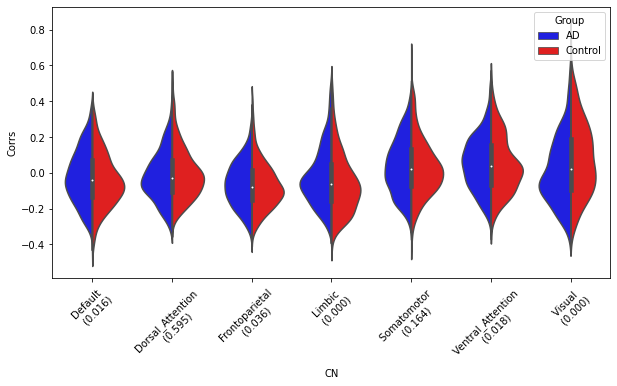

In [51]:
corrAD = []
corrCtrl = []
for ix in range(len(fsAD)):
    corrAD = corrAD + fsAD[ix].wUcorrsAll
for ix in range(len(fsCtrl)):
    corrCtrl = corrCtrl + fsCtrl[ix].wUcorrsAll
groupLabs = ["AD"] * (len(corrAD)*7) + ["Control"] * (len(corrCtrl)*7)

cnLabs = []
corrAD = np.array(corrAD)
corrADflat = []
corrCtrl = np.array(corrCtrl)
corrCtrlflat = []
for ix in range(7):
    corrADflat = corrADflat + list(corrAD[:, ix])
    cnLabs = cnLabs + [rowNames[ix]] * len(corrAD[:, ix])
    
for ix in range(7):
    corrCtrlflat = corrCtrlflat + list(corrCtrl[:, ix])
    cnLabs = cnLabs + [rowNames[ix]] * len(corrCtrl[:, ix])
corrs = corrADflat + corrCtrlflat

corrDF = pd.DataFrame({"Corrs":np.array(corrs), "CN":cnLabs, "Group":groupLabs})

xticklabs = []
for nam in rowNames:
    curSubAD = corrDF[(corrDF["CN"] == nam) & (corrDF["Group"] == "AD")]
    curSubCtrl = corrDF[(corrDF["CN"] == nam) & (corrDF["Group"] == "Control")]
    restt = scipy.stats.ttest_ind(curSubAD["Corrs"], curSubCtrl["Corrs"])
    resrs = scipy.stats.ranksums(curSubAD["Corrs"], curSubCtrl["Corrs"])
    resks = scipy.stats.kstest(curSubAD["Corrs"], curSubCtrl["Corrs"])
    xticklabs.append(f"{nam} \n ({resks.pvalue:.3f})")

plt.figure(figsize=[10, 5])
sns.violinplot(x="CN", y="Corrs", hue="Group", data=corrDF, 
               split=True, palette = {"AD":'blue', "Control":'red'}, order=rowNames)
plt.xticks(np.arange(7), xticklabs)
_ = plt.xticks(rotation=45)

#### Dist of maximal corrs among the 7 CNs

In [52]:
maxCorrNetAD = []
for ix in range(len(fsAD)):
    maxCorrNetAD = maxCorrNetAD + list(np.array(rowNames)[np.array(fsAD[ix].wUcorrsAll).argmax(axis=1)])
maxCorrNetCtrl = []
for ix in range(len(fsCtrl)):
    maxCorrNetCtrl = maxCorrNetCtrl + list(np.array(rowNames)[np.array(fsCtrl[ix].wUcorrsAll).argmax(axis=1)])

In [53]:
ADct = []
Ctrlct = []
for nam in rowNames:
    ADct.append(maxCorrNetAD.count(nam))
    Ctrlct.append(maxCorrNetCtrl.count(nam))
ADfreq = np.array(ADct)/np.sum(ADct)
Ctrlfreq = np.array(Ctrlct)/np.sum(Ctrlct)

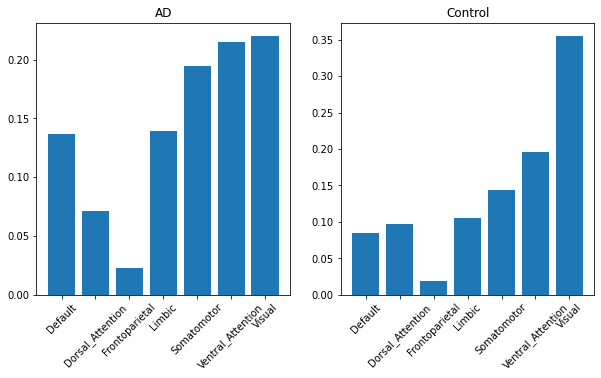

In [54]:
plt.figure(figsize=[10, 5])
plt.subplot(121)
plt.title("AD")
plt.bar(rowNames, ADfreq)
plt.xticks(rotation=45)

plt.subplot(122)
plt.title("Control")
plt.bar(rowNames, Ctrlfreq)
_ = plt.xticks(rotation=45)

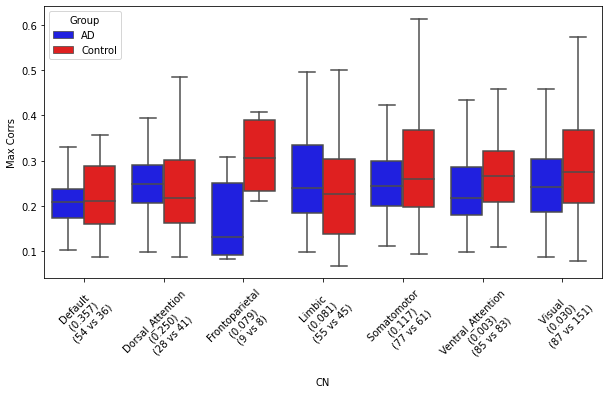

In [55]:
cnLabsMax = []
corrADMaxflat = []
corrCtrlMaxflat = []
for ix in range(len(fsAD)):
    curF = fsAD[ix]
    for ixx in range(len(curF.wUcorrsAll)):
        corrADMaxflat.append(np.max(curF.wUcorrsAll[ixx]))
        cnLabsMax.append(rowNames[np.argmax(curF.wUcorrsAll[ixx])])
    
for ix in range(len(fsCtrl)):
    curF = fsCtrl[ix]
    for ixx in range(len(curF.wUcorrsAll)):
        corrCtrlMaxflat.append(np.max(curF.wUcorrsAll[ixx]))
        cnLabsMax.append(rowNames[np.argmax(curF.wUcorrsAll[ixx])])
        
corrsMax = corrADMaxflat + corrCtrlMaxflat
groupLabsMax = ["AD"]* len(corrADMaxflat) + ["Control"] * len(corrCtrlMaxflat)
corrDF = pd.DataFrame({"Corrs":np.array(corrsMax), "CN":cnLabsMax, "Group":groupLabsMax})

xticklabs = []
for nam in rowNames:
    curSubAD = corrDF[(corrDF["CN"] == nam) & (corrDF["Group"] == "AD")]
    curSubCtrl = corrDF[(corrDF["CN"] == nam) & (corrDF["Group"] == "Control")]
    restt = scipy.stats.ttest_ind(curSubAD["Corrs"], curSubCtrl["Corrs"])
    resrs = scipy.stats.ranksums(curSubAD["Corrs"], curSubCtrl["Corrs"])
    resks = scipy.stats.kstest(curSubAD["Corrs"], curSubCtrl["Corrs"])
    xticklabs.append(f"{nam} \n ({resks.pvalue:.3f}) \n ({len(curSubAD)} vs {len(curSubCtrl)})")

plt.figure(figsize=[10, 5])
#sns.violinplot(x="CN", y="Corrs", hue="Group", data=corrDF, 
#               split=True, palette = {"AD":'blue', "Control":'red'}, order=rowNames)
sns.boxplot(x="CN", y="Corrs", hue="Group", data=corrDF, showfliers=False, 
               palette = {"AD":'blue', "Control":'red'}, order=rowNames)
plt.xticks(np.arange(7), xticklabs)
plt.ylabel("Max Corrs")
_ = plt.xticks(rotation=45)

####  Dist of dwell times for maximal corrs of 7 nets 

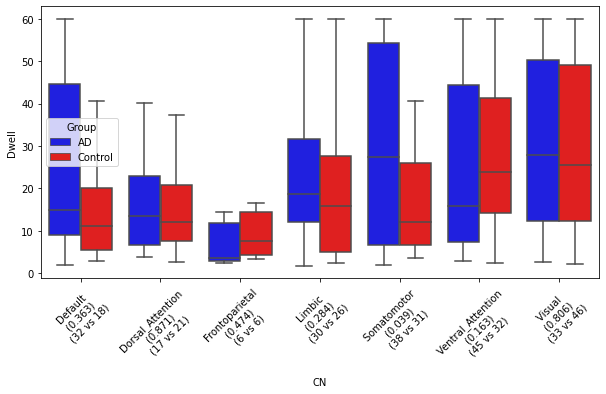

In [57]:
curDNLAD = []
curDNLCtrl = []
curDwell = []

for ix in range(len(fsAD)):
    curDwellCt = ddict(float)
    curMlabs = np.array(rowNames)[np.array(fsAD[ix].wUcorrsAll).argmax(axis=1)]
    for ixx, curMlab in enumerate(curMlabs):
        curDwellCt[curMlab] += fsAD[ix].dwell[ixx]
    allIts = list(curDwellCt.items())
    curDwell = curDwell + [ixxx[1] for ixxx in allIts]
    curDNLAD = curDNLAD + [ixxx[0] for ixxx in allIts]

for ix in range(len(fsCtrl)):
    curDwellCt = ddict(float)
    curMlabs = np.array(rowNames)[np.array(fsCtrl[ix].wUcorrsAll).argmax(axis=1)]
    for ixx, curMlab in enumerate(curMlabs):
        curDwellCt[curMlab] += fsCtrl[ix].dwell[ixx]
    allIts = list(curDwellCt.items())
    curDwell = curDwell + [ixxx[1] for ixxx in allIts]
    curDNLCtrl = curDNLCtrl + [ixxx[0] for ixxx in allIts]
    
# below do not consider a subject have multiple segment for same label
# for ix in range(len(fsAD)):
#     curDwell = curDwell + list(fsAD[ix].dwell)
#     curDNLAD = curDNLAD + list(np.array(rowNames)[np.array(fsAD[ix].wUcorrsAll).argmax(axis=1)])
# for ix in range(len(fsCtrl)):
#     curDwell = curDwell + list(fsCtrl[ix].dwell)
#     curDNLCtrl = curDNLCtrl + list(np.array(rowNames)[np.array(fsCtrl[ix].wUcorrsAll).argmax(axis=1)])
    
dwellDF = pd.DataFrame({"Dwell": curDwell, "CN": curDNLAD+curDNLCtrl, 
                        "Group": ["AD"]*len(curDNLAD) + ["Control"]*len(curDNLCtrl)})

xticklabs = []
for nam in rowNames:
    curSubAD = dwellDF[(dwellDF["CN"] == nam) & (dwellDF["Group"] == "AD")]
    curSubCtrl = dwellDF[(dwellDF["CN"] == nam) & (dwellDF["Group"] == "Control")]
    restt = scipy.stats.ttest_ind(curSubAD["Dwell"], curSubCtrl["Dwell"])
    resrs = scipy.stats.ranksums(curSubAD["Dwell"], curSubCtrl["Dwell"])
    resks = scipy.stats.kstest(curSubAD["Dwell"], curSubCtrl["Dwell"])
    # xticklabs.append(f"{nam} \n ({restt.pvalue:.3f})")
    xticklabs.append(f"{nam} \n ({resks.pvalue:.3f}) \n ({len(curSubAD)} vs {len(curSubCtrl)})")
    
plt.figure(figsize=[10, 5])
sns.boxplot(x="CN", y="Dwell", hue="Group", data=dwellDF, palette = {"AD":'blue', "Control":'red'}, order=rowNames, showfliers=False)
#sns.violinplot(x="CN", y="Dwell", hue="Group", data=dwellDF, split=True, palette = {"AD":'blue', "Control":'red'}, order=rowNames)
plt.xticks(np.arange(7), xticklabs)
_ = plt.xticks(rotation=45)

#### mean of wU with label assigned by maximal correlations

In [58]:
wUADdict = ddict(list)
wUCtrldict = ddict(list)

for ix in range(len(fsAD)):
    curFs = fsAD[ix]
    CNlabs = list(np.array(rowNames)[np.array(curFs.wUcorrsAll).argmax(axis=1)])
    for ixx, CNlab in enumerate(CNlabs):
        curWU = curFs.wUAll[:, ixx]
        wUADdict[CNlab].append(curWU)
        
for ix in range(len(fsCtrl)):
    curFs = fsCtrl[ix]
    CNlabs = list(np.array(rowNames)[np.array(curFs.wUcorrsAll).argmax(axis=1)])
    for ixx, CNlab in enumerate(CNlabs):
        curWU = curFs.wUAll[:, ixx]
        wUCtrldict[CNlab].append(curWU)

In [934]:
nDis = 8
for nam in rowNames:
    curWUmeanAD = np.array(wUADdict[nam]).mean(axis=0)
    curWUmeanCtrl = np.array(wUCtrldict[nam]).mean(axis=0)
    # curWUmeanAD = discretVec(curWUmeanAD, np.linspace(0, 1, nDis+1))
    # curWUmeanAD = discretVec(curWUmeanCtrl, np.linspace(0, 1, nDis+1))
    mFAD = minmax(curWUmeanAD)
    mFCtrl = minmax(curWUmeanCtrl)
    outAD = U2BrainVec(reorderU(mFAD))
    outCtrl = U2BrainVec(reorderU(mFCtrl))
    np.savetxt(f"./brainPlotFils/wUmeanAD_{nam}.txt", outAD)
    np.savetxt(f"./brainPlotFils/wUmeanCtrl_{nam}.txt", outCtrl)
    


In [935]:
for ix, nam in enumerate(rowNames):
    curFcRMM = fcRarrMM[ix, :]
    outVec = U2BrainVec(reorderU(curFcRMM))
    np.savetxt(f"./brainPlotFils/CN_{nam}.txt", outVec)

####  Corr between clustering center and CNs

In [59]:
wUADAll = np.concatenate([fs.wUAll for fs in fsAD], axis=1)
wUCtrlAll = np.concatenate([fs.wUAll for fs in fsCtrl], axis=1)
dwellADAll = np.concatenate([fs.dwell for fs in fsAD])
dwellCtrlAll = np.concatenate([fs.dwell for fs in fsCtrl])

In [60]:
cluAD = KMeans(n_clusters=7, random_state=0).fit(wUADAll.T)
ADcluCenter = cluAD.cluster_centers_
cluCtrl = KMeans(n_clusters=7, random_state=0).fit(wUCtrlAll.T)
CtrlcluCenter = cluCtrl.cluster_centers_

In [61]:
ADcorrsCens = []
for ix in range(ADcluCenter.shape[0]):
    curCenterMM = minmax(ADcluCenter[ix, :])
    curCorrs = []
    for ixx in range(fcRarrMM.shape[0]):
        curCorrs.append(ss.pearsonr(fcRarrMM[ixx, :], curCenterMM)[0])
    ADcorrsCens.append(curCorrs)

In [62]:
CtrlcorrsCens = []
for ix in range(CtrlcluCenter.shape[0]):
    curCenterMM = minmax(CtrlcluCenter[ix, :])
    curCorrs = []
    for ixx in range(fcRarrMM.shape[0]):
        curCorrs.append(ss.pearsonr(fcRarrMM[ixx, :], curCenterMM)[0])
    CtrlcorrsCens.append(curCorrs)

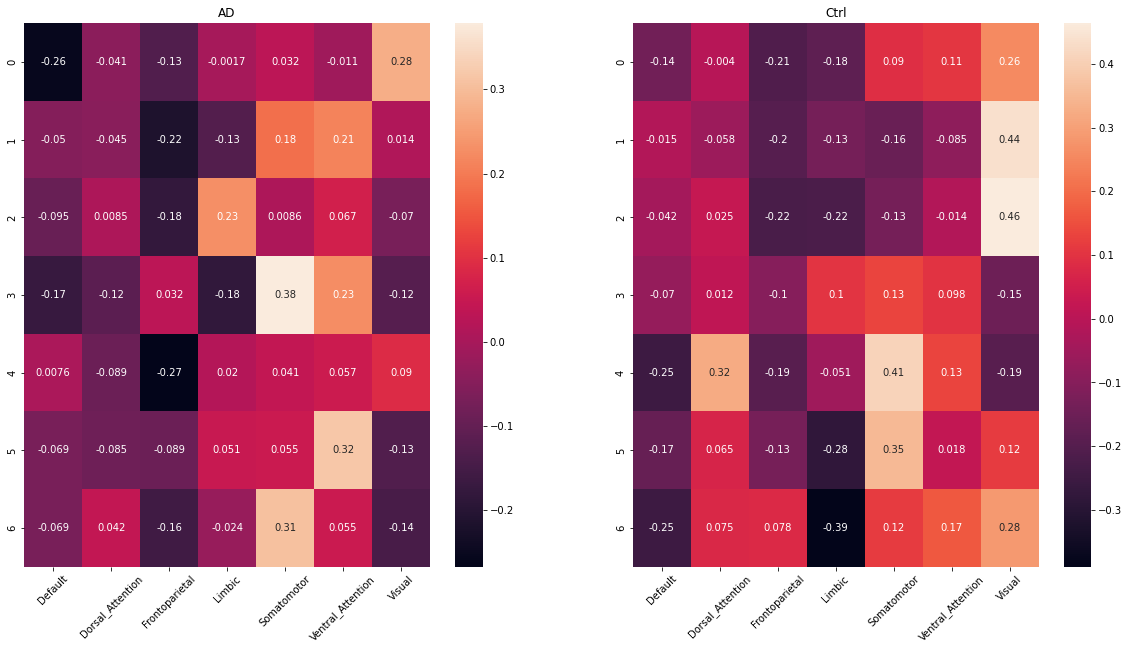

In [63]:
plt.figure(figsize=[20, 10])
plt.subplot(121)
sns.heatmap(ADcorrsCens, annot=True)
plt.title("AD")
plt.xticks(np.arange(7)+0.5, rowNames, rotation=45)

plt.subplot(122)
sns.heatmap(CtrlcorrsCens, annot=True)
plt.title("Ctrl")
_ =  plt.xticks(np.arange(7)+0.5, rowNames, rotation=45)

#### Clustering wU after minmax

In [66]:
wUlabs = np.concatenate([np.ones(wUADAll.shape[1]),np.zeros(wUCtrlAll.shape[1])])
wUAll = np.concatenate([wUADAll, wUCtrlAll], axis=1)
dwellAll = np.concatenate([dwellADAll, dwellCtrlAll])
wUlabsRaw = np.array(["AD"] * wUADAll.shape[1] + ["Control"] * wUCtrlAll.shape[1])
wUAllMM = (wUAll - wUAll.min(axis=0))/(wUAll.max(axis=0)-wUAll.min(axis=0))

In [67]:
cluAll = KMeans(n_clusters=2, random_state=0).fit(wUAllMM.T)
#cluAll = AgglomerativeClustering(n_clusters=2).fit(wUAllMM.T)
#cluAll = SpectralClustering(n_clusters=2, random_state=0).fit(wUAllMM.T)
cTb = np.array(pd.crosstab(wUlabs, cluAll.labels_))
OR, pv = fisher_exact(cTb)
pStr = f"The odds ratio between control and AD groups is {OR:.3f}, the pvalue of the fisher exact test is {pv:.3f}."
print(pStr)

pd.crosstab(wUlabsRaw, cluAll.labels_)

The odds ratio between control and AD groups is 1.541, the pvalue of the fisher exact test is 0.002.


col_0,0,1
row_0,,
AD,174,221
Control,233,192


In [70]:
cluAll = KMeans(n_clusters=7, random_state=0).fit(wUAllMM.T)
#cluAll = AgglomerativeClustering(n_clusters=7).fit(wUAllMM.T)
#cluAll = SpectralClustering(n_clusters=7, random_state=0).fit(wUAllMM.T)
cTb = np.array(pd.crosstab(wUlabs, cluAll.labels_))
chi2, pv, _, _ = chi2_contingency(cTb)
pStr = f"The chisq stat is {chi2:.3f}, the pvalue of the test is {pv:.3f}."
print(pStr)
pd.crosstab(wUlabsRaw, cluAll.labels_)

The chisq stat is 57.131, the pvalue of the test is 0.000.


col_0,0,1,2,3,4,5,6
row_0,,,,,,,
AD,53,77,37,40,55,68,65
Control,39,30,82,85,54,81,54


##### R spectral clustering (I do not use it)

In [946]:
from rpy2 import robjects as robj
r = robj.r
Rstr = """

spectral_clustering <- function(X, # matrix of data points
                                nn = 10, # the k nearest neighbors to consider
                                n_eig = 2) # m number of eignenvectors to keep
{
  mutual_knn_graph <- function(X, nn = 10)
  {
    D <- as.matrix( dist(X) ) # matrix of euclidean distances between data points in X
    
    # intialize the knn matrix
    knn_mat <- matrix(0,
                      nrow = nrow(X),
                      ncol = nrow(X))
    
    # find the 10 nearest neighbors for each point
    for (i in 1: nrow(X)) {
      neighbor_index <- order(D[i,])[2:(nn + 1)]
      knn_mat[i,][neighbor_index] <- 1 
    }
   
    # Now we note that i,j are neighbors iff K[i,j] = 1 or K[j,i] = 1 
    knn_mat <- knn_mat + t(knn_mat) # find mutual knn
    
    knn_mat[ knn_mat == 2 ] = 1
    
    return(knn_mat)
  }
  
  graph_laplacian <- function(W, normalized = TRUE)
  {
    stopifnot(nrow(W) == ncol(W)) 
    
    g = colSums(W) # degrees of vertices
    n = nrow(W)
    
    if(normalized)
    {
      D_half = diag(1 / sqrt(g) )
      return( diag(n) - D_half %*% W %*% D_half )
    }
    else
    {
      return( diag(g) - W )
    }
  }
  
  W = mutual_knn_graph(X) # 1. matrix of similarities
  L = graph_laplacian(W) # 2. compute graph laplacian
  ei = eigen(L, symmetric = TRUE) # 3. Compute the eigenvectors and values of L
  n = nrow(L)
  return(ei$vectors[,(n - n_eig):(n - 1)]) # return the eigenvectors of the n_eig smallest eigenvalues

}

"""

r(Rstr)

RSpeCluFn = r["spectral_clustering"]
RwUAllT = r["matrix"](robj.FloatVector(np.ascontiguousarray(wUAll.T.reshape(-1))), nrow=wUAll.shape[1], byrow=True)
wUAllT_Sc = np.array(RSpeCluFn(RwUAllT, n_eig=20))

In [947]:
cluAll1 = KMeans(n_clusters=2, random_state=0).fit(wUAllT_Sc)
elabs = cluAll1.labels_

cTb = np.array(pd.crosstab(wUlabs, elabs))
OR, pv = fisher_exact(cTb)
pStr = f"The odds ratio between control and AD groups is {OR:.3f}, the pvalue of the fisher exact test is {pv:.3f}."
print(pStr)

pd.crosstab(wUlabsRaw, elabs)

The odds ratio between control and AD groups is 0.549, the pvalue of the fisher exact test is 0.000.


col_0,0,1
row_0,,
AD,263,132
Control,222,203


In [948]:
cluAll1 = KMeans(n_clusters=3, random_state=0).fit(wUAllT_Sc)
cTb = np.array(pd.crosstab(wUlabs, cluAll1.labels_))
chi2, pv, _, _ = chi2_contingency(cTb)
pStr = f"The chisq stat is {chi2:.3f}, the pvalue of the test is {pv:.3f}."
print(pStr)
pd.crosstab(wUlabsRaw, cluAll1.labels_)

The chisq stat is 36.014, the pvalue of the test is 0.000.


col_0,0,1,2
row_0,,,
AD,1,253,141
Control,16,193,216


12.667965779467679 9.857469969969967
14.760037878787879 9.909564860426931


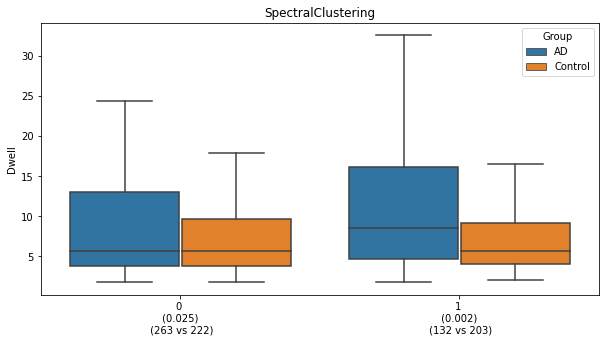

In [949]:
cluAll1 = KMeans(n_clusters=2, random_state=0).fit(wUAllT_Sc)
elabsSC = cluAll1.labels_
cluDFSC  = pd.DataFrame({"Dwell": dwellAll, "elabs": elabsSC, "Group":["AD"]*len(dwellADAll)+["Control"]*len(dwellCtrlAll)})

                       
xticklabsSC = []
for ix in range(np.max(elabsSC)+1):
    curAD = cluDFSC[(cluDFSC["elabs"]==ix) & (cluDFSC["Group"]=="AD")]
    curCtrl = cluDFSC[(cluDFSC["elabs"]==ix) & (cluDFSC["Group"]=="Control")]
    print(np.mean(curAD["Dwell"]), np.mean(curCtrl["Dwell"]))
    restt = scipy.stats.ttest_ind(curAD["Dwell"], curCtrl["Dwell"])
    resrs = scipy.stats.ranksums(curAD["Dwell"], curCtrl["Dwell"])
    resks = scipy.stats.kstest(curAD["Dwell"], curCtrl["Dwell"])
    xticklabsSC.append(f"{ix} \n ({restt.pvalue:.3f}) \n ({len(curAD)} vs {len(curCtrl)})")
    

plt.figure(figsize=[10, 5])
plt.title("SpectralClustering")
sns.boxplot(x="elabs", y="Dwell", hue="Group", data=cluDFSC, showfliers=False, order=np.arange(np.max(elabsSC)+1))
#sns.violinplot(x="elabs", y="Dwell", hue="ClusterMethod", data=cluDFBoth, split=True)
plt.xlabel("")
_ = plt.xticks(np.arange(np.max(elabsSC)+1), xticklabsSC)

#### PCA Kmeans

Text(0.5, 0, 'Num comps')

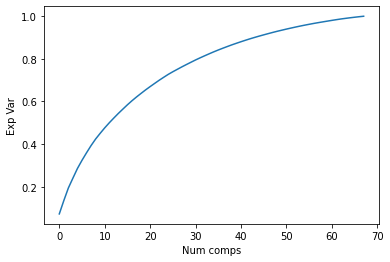

In [82]:
# select ncomp for PCA
perComp = 0.8
pca = PCA(n_components=wUAllMM.shape[0], random_state=0)
pcafit = pca.fit(wUAllMM.T)
cmVs = np.cumsum(pcafit.explained_variance_ratio_)

nComp =  np.where(cmVs>=perComp)[0][0] + 1
plt.plot(np.cumsum(pcafit.explained_variance_ratio_))
plt.ylabel("Exp Var")
plt.xlabel("Num comps")

Text(0.5, 0, 'Num comps')

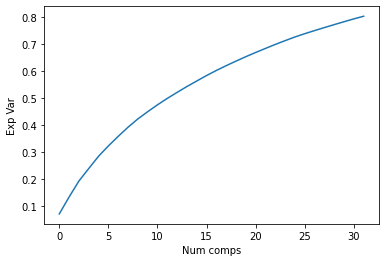

In [83]:
# PCA first 
pca = PCA(n_components=nComp, random_state=0)
pcafit = pca.fit(wUAllMM.T)
plt.plot(np.cumsum(pcafit.explained_variance_ratio_))
plt.ylabel("Exp Var")
plt.xlabel("Num comps")

In [84]:
rdwUAll = pcafit.transform(wUAllMM.T)
cluAll = KMeans(n_clusters=2, random_state=0).fit(rdwUAll)
#cluAll = AgglomerativeClustering(n_clusters=2).fit(rdwUAll)
#cluAll = SpectralClustering(n_clusters=2, assign_labels='discretize', random_state=0).fit(wUAll.T)
elabs = cluAll.labels_

#cluAll = GaussianMixture(n_components=2).fit(rdwUAll)
#elabs = cluAll.predict(rdwUAll)
cTb = np.array(pd.crosstab(wUlabs, elabs))
OR, pv = fisher_exact(cTb)
pStr = f"The odds ratio between control and AD groups is {OR:.3f}, the pvalue of the fisher exact test is {pv:.3f}."
print(pStr)

pd.crosstab(wUlabsRaw, elabs)

The odds ratio between control and AD groups is 1.366, the pvalue of the fisher exact test is 0.029.


col_0,0,1
row_0,,
AD,162,233
Control,207,218


In [85]:
cluAll = KMeans(n_clusters=4, random_state=0).fit(rdwUAll)
#cluAll = AgglomerativeClustering(n_clusters=7).fit(rdwUAll)
# cluAll = SpectralClustering(n_clusters=7, random_state=0).fit(rdwUAll)
elabs = cluAll.labels_

#cluAll = GaussianMixture(n_components=4, random_state=0).fit(rdwUAll)
#elabs = cluAll.predict(rdwUAll)

cTb = np.array(pd.crosstab(wUlabs, elabs))
chi2, pv, _, _ = chi2_contingency(cTb)
pStr = f"The chisq stat is {chi2:.3f}, the pvalue of the test is {pv:.3f}."
print(pStr)
pd.crosstab(wUlabsRaw, elabs)

The chisq stat is 27.277, the pvalue of the test is 0.000.


col_0,0,1,2,3
row_0,,,,
AD,93,82,88,132
Control,85,153,93,94


##### Choose the n of clusters by BIC

In [86]:
def KmeanBIC(kmCluObj, Cn=1):
    nclu = kmCluObj.n_clusters
    nsps = len(kmCluObj.labels_)
    nDim = kmCluObj.cluster_centers_.shape[1]
    log_lik = np.log(kmCluObj.inertia_/nsps/nDim)
    BIC = log_lik + Cn*np.log(np.log(nsps*nDim))*np.log(nsps)*(nclu-1)/nsps
    return BIC
    

3


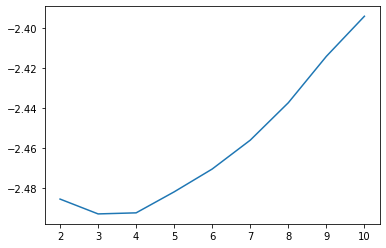

In [89]:
n_clus = list(range(2, 11))
BICs = []
for n_clu in n_clus:
    curClu = KMeans(n_clusters=n_clu, random_state=0).fit(rdwUAll)
    BICs.append(KmeanBIC(curClu, Cn=2))
plt.plot(n_clus, BICs)
ncluOpt = n_clus[np.argmin(BICs)]
print(ncluOpt)

In [90]:
cluAll = KMeans(n_clusters=ncluOpt, random_state=0).fit(rdwUAll)
elabs = cluAll.labels_
ords = np.arange(np.max(elabs)+1)
cluMeans = []
for curOrd in ords:
    curVec = wUAll.T[elabs==curOrd, :].mean(axis=0)
    outVec = U2BrainVec(reorderU(minmax(curVec)))
    np.savetxt(f"./brainPlotFils/PCA_KM_{len(ords)}_{curOrd}.txt", outVec)
    pd.DataFrame({"Name": regionNames, "Vec": minmax(curVec)}).to_csv(f"./brainPlotFils/PCA_KM_{len(ords)}_{curOrd}.csv", index=False)

##### Non add dwell of the same subject together

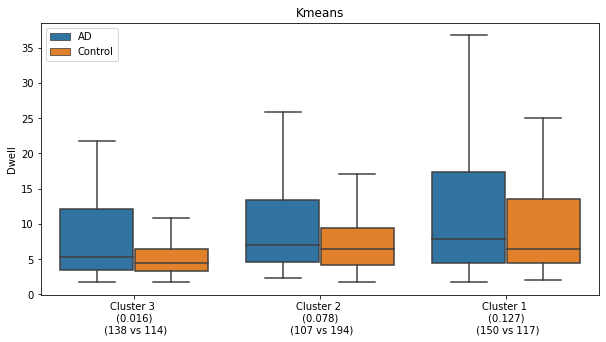

In [91]:
nclu = ncluOpt
cluAll = KMeans(n_clusters=nclu, random_state=0).fit(rdwUAll)
elabsKM = cluAll.labels_

cluAll = GaussianMixture(n_components=nclu, random_state=0).fit(rdwUAll)
elabsGM = cluAll.predict(rdwUAll)



cluDFKM  = pd.DataFrame({"Dwell": dwellAll, "elabs": elabsKM, "Group":["AD"]*len(dwellADAll)+["Control"]*len(dwellCtrlAll)})
cluDFGM  = pd.DataFrame({"Dwell": dwellAll, "elabs": elabsGM, "Group":["AD"]*len(dwellADAll)+["Control"]*len(dwellCtrlAll)})

xticklabsKM = []
pvsKM = []
for ix in range(np.max(elabsKM)+1):
    curAD = cluDFKM[(cluDFKM["elabs"]==ix) & (cluDFKM["Group"]=="AD")]
    curCtrl = cluDFKM[(cluDFKM["elabs"]==ix) & (cluDFKM["Group"]=="Control")]
    restt = scipy.stats.ttest_ind(curAD["Dwell"], curCtrl["Dwell"])
    resrs = scipy.stats.ranksums(curAD["Dwell"], curCtrl["Dwell"])
    resks = scipy.stats.kstest(curAD["Dwell"], curCtrl["Dwell"])
    pv = restt.pvalue
    pvsKM.append(pv)
    xticklabsKM.append(f"Cluster {ix+1} \n ({pv:.3f}) \n ({len(curAD)} vs {len(curCtrl)})")
    
# ignore orignal cluster idx
# xticklabsKM = []
# for ix in range(np.max(elabsKM)+1):
#     curAD = cluDFKM[(cluDFKM["elabs"]==ix) & (cluDFKM["Group"]=="AD")]
#     curCtrl = cluDFKM[(cluDFKM["elabs"]==ix) & (cluDFKM["Group"]=="Control")]
#     restt = scipy.stats.ttest_ind(curAD["Dwell"], curCtrl["Dwell"])
#     resrs = scipy.stats.ranksums(curAD["Dwell"], curCtrl["Dwell"])
#     resks = scipy.stats.kstest(curAD["Dwell"], curCtrl["Dwell"])
#     pv = restt.pvalue
#     xticklabsKM.append(f"Cluster {np.argsort(pvsKM)[ix]+1} \n ({pv:.3f}) \n ({len(curAD)} vs {len(curCtrl)})")
                       
xticklabsGM = []
pvsGM = []
for ix in range(np.max(elabsGM)+1):
    curAD = cluDFGM[(cluDFGM["elabs"]==ix) & (cluDFGM["Group"]=="AD")]
    curCtrl = cluDFGM[(cluDFGM["elabs"]==ix) & (cluDFGM["Group"]=="Control")]
    restt = scipy.stats.ttest_ind(curAD["Dwell"], curCtrl["Dwell"])
    resrs = scipy.stats.ranksums(curAD["Dwell"], curCtrl["Dwell"])
    resks = scipy.stats.kstest(curAD["Dwell"], curCtrl["Dwell"])
    pv = restt.pvalue
    pvsGM.append(pv)
    xticklabsGM.append(f"Cluster {ix+1} \n ({pv:.3f}) \n ({len(curAD)} vs {len(curCtrl)})")
    

plt.figure(figsize=[10, 5])
# plt.subplot(211)
plt.title("Kmeans")
sns.boxplot(x="elabs", y="Dwell", hue="Group", data=cluDFKM, showfliers=False, order=np.argsort(pvsKM))
#sns.violinplot(x="elabs", y="Dwell", hue="ClusterMethod", data=cluDFBoth, split=True)
plt.xlabel("")
plt.legend(loc="upper left")
_ = plt.xticks(np.arange(np.max(elabsKM)+1), np.array(xticklabsKM)[np.argsort(pvsKM)])
# plt.subplot(212)
# plt.title("GauMix")
# sns.boxplot(x="elabs", y="Dwell", hue="Group", data=cluDFGM, showfliers=False, order=np.argsort(pvsGM))
# #sns.violinplot(x="elabs", y="Dwell", hue="ClusterMethod", data=cluDFBoth, split=True)
# plt.xlabel("")
# _ = plt.xticks(np.arange(np.max(elabsGM)+1), np.array(xticklabsGM)[np.argsort(pvsGM)])

plt.savefig(f"./plots/boxplot_wUKmeans_{nclu}.jpg", bbox_inches='tight')

In [92]:
elabsKMused = elabsKM

##### add dwell of the same subject together (not used now)

In [93]:
nclu = ncluOpt

In [94]:
# KM 
cluAll = KMeans(n_clusters=nclu, random_state=0).fit(rdwUAll)
elabsKM = cluAll.labels_

curDwell = []
curCluLabAD = []
curCluLabCtrl = []
flag = 0
curElabs = elabsKM
for ix in range(len(fsAD)):
    curDwellCt = ddict(float)
    curMlabs = curElabs[flag:(flag+len(fsAD[ix].dwell))]
    for ixx, curMlab in enumerate(curMlabs):
        curDwellCt[curMlab] += fsAD[ix].dwell[ixx]
    allIts = list(curDwellCt.items())
    curDwell = curDwell + [ixxx[1] for ixxx in allIts]
    curCluLabAD = curCluLabAD + [ixxx[0] for ixxx in allIts]
    flag += len(fsAD[ix].dwell)

#flag = 0
for ix in range(len(fsCtrl)):
    curDwellCt = ddict(float)
    curMlabs = curElabs[flag:(flag+len(fsCtrl[ix].dwell))]
    for ixx, curMlab in enumerate(curMlabs):
        curDwellCt[curMlab] += fsCtrl[ix].dwell[ixx]
    allIts = list(curDwellCt.items())
    curDwell = curDwell + [ixxx[1] for ixxx in allIts]
    curCluLabCtrl = curCluLabCtrl + [ixxx[0] for ixxx in allIts]
    flag += len(fsCtrl[ix].dwell)

cluDFKM  = pd.DataFrame({"Dwell": curDwell, "elabs": np.concatenate([curCluLabAD, curCluLabCtrl]), 
                         "Group":["AD"]*len(curCluLabAD)+["Control"]*len(curCluLabCtrl)})

xticklabsKM = []
pvsKM = []
for ix in range(np.max(elabsKM)+1):
    curAD = cluDFKM[(cluDFKM["elabs"]==ix) & (cluDFKM["Group"]=="AD")]
    curCtrl = cluDFKM[(cluDFKM["elabs"]==ix) & (cluDFKM["Group"]=="Control")]
    restt = scipy.stats.ttest_ind(curAD["Dwell"], curCtrl["Dwell"])
    resrs = scipy.stats.ranksums(curAD["Dwell"], curCtrl["Dwell"])
    resks = scipy.stats.kstest(curAD["Dwell"], curCtrl["Dwell"])
    pv = restt.pvalue
    pvsKM.append(pv)
    xticklabsKM.append(f"{ix} \n ({pv:.3f}) \n ({len(curAD)} vs {len(curCtrl)})")

In [95]:
# GM
cluAll = GaussianMixture(n_components=nclu, random_state=0).fit(rdwUAll)
elabsGM = cluAll.predict(rdwUAll)

curDwell = []
curCluLabAD = []
curCluLabCtrl = []
flag = 0
curElabs = elabsGM
for ix in range(len(fsAD)):
    curDwellCt = ddict(float)
    curMlabs = curElabs[flag:(flag+len(fsAD[ix].dwell))]
    for ixx, curMlab in enumerate(curMlabs):
        curDwellCt[curMlab] += fsAD[ix].dwell[ixx]
    allIts = list(curDwellCt.items())
    curDwell = curDwell + [ixxx[1] for ixxx in allIts]
    curCluLabAD = curCluLabAD + [ixxx[0] for ixxx in allIts]
    flag += len(fsAD[ix].dwell)

#flag = 0
for ix in range(len(fsCtrl)):
    curDwellCt = ddict(float)
    curMlabs = curElabs[flag:(flag+len(fsCtrl[ix].dwell))]
    for ixx, curMlab in enumerate(curMlabs):
        curDwellCt[curMlab] += fsCtrl[ix].dwell[ixx]
    allIts = list(curDwellCt.items())
    curDwell = curDwell + [ixxx[1] for ixxx in allIts]
    curCluLabCtrl = curCluLabCtrl + [ixxx[0] for ixxx in allIts]
    flag += len(fsCtrl[ix].dwell)

cluDFGM  = pd.DataFrame({"Dwell": curDwell, "elabs": np.concatenate([curCluLabAD, curCluLabCtrl]), 
                         "Group":["AD"]*len(curCluLabAD)+["Control"]*len(curCluLabCtrl)})

pvsGM = []
xticklabsGM = []
for ix in range(np.max(elabsGM)+1):
    curAD = cluDFGM[(cluDFGM["elabs"]==ix) & (cluDFGM["Group"]=="AD")]
    curCtrl = cluDFGM[(cluDFGM["elabs"]==ix) & (cluDFGM["Group"]=="Control")]
    restt = scipy.stats.ttest_ind(curAD["Dwell"], curCtrl["Dwell"])
    resrs = scipy.stats.ranksums(curAD["Dwell"], curCtrl["Dwell"])
    resks = scipy.stats.kstest(curAD["Dwell"], curCtrl["Dwell"])
    pv = restt.pvalue
    pvsGM.append(pv)
    xticklabsGM.append(f"{ix} \n ({pv:.3f}) \n ({len(curAD)} vs {len(curCtrl)})")

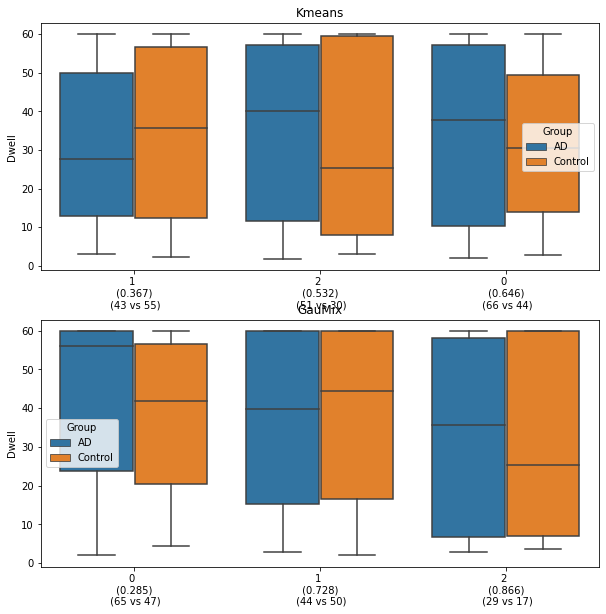

In [96]:
plt.figure(figsize=[10, 10])
plt.subplot(211)
plt.title("Kmeans")
sns.boxplot(x="elabs", y="Dwell", hue="Group", data=cluDFKM, showfliers=False, order=np.argsort(pvsKM))
#sns.violinplot(x="elabs", y="Dwell", hue="ClusterMethod", data=cluDFBoth, split=True)
plt.xlabel("")
_ = plt.xticks(np.arange(np.max(elabsKM)+1), np.array(xticklabsKM)[np.argsort(pvsKM)])
plt.subplot(212)
plt.title("GauMix")
sns.boxplot(x="elabs", y="Dwell", hue="Group", data=cluDFGM, showfliers=False, order=np.argsort(pvsGM))
#sns.violinplot(x="elabs", y="Dwell", hue="ClusterMethod", data=cluDFBoth, split=True)
plt.xlabel("")
_ = plt.xticks(np.arange(np.max(elabsGM)+1), np.array(xticklabsGM)[np.argsort(pvsGM)])

#### Reg wU on CN (not used)

sample size is 68

In [97]:
OLSparassAD = []
for ix in range(wUADAll.shape[1]):
    curY = wUADAll[:, ix]
    curOLS = sm.OLS(curY, fcRarr.T )
    curOLSfit = curOLS.fit()
    OLSparassAD.append(curOLSfit.params)
OLSparassAD = np.array(OLSparassAD)

OLSparassCtrl = []
for ix in range(wUCtrlAll.shape[1]):
    curY = wUCtrlAll[:, ix]
    curOLS = sm.OLS(curY, fcRarr.T )
    curOLSfit = curOLS.fit()
    OLSparassCtrl.append(curOLSfit.params)
OLSparassCtrl = np.array(OLSparassCtrl)

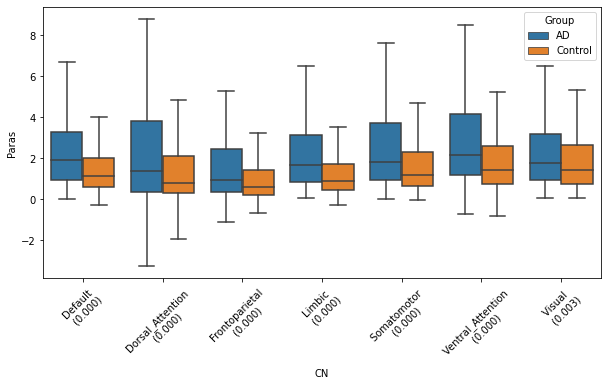

In [99]:
# Paras dist for each CN 
OLSparass = np.concatenate([OLSparassAD.reshape(-1), OLSparassCtrl.reshape(-1)])
CNLabs = rowNames * (OLSparassAD.shape[0]+OLSparassCtrl.shape[0])
grpLabs = ["AD"] *(OLSparassAD.shape[0]*7) +["Control"] *(OLSparassCtrl.shape[0]*7) 
OLSparasDF = pd.DataFrame({"Paras": OLSparass, "CN": CNLabs, "Group":grpLabs})

xticklabs = []
curDF = OLSparasDF
for nam in rowNames:
    curSubAD = curDF[(curDF["CN"] == nam) & (curDF["Group"] == "AD")]
    curSubCtrl = curDF[(curDF["CN"] == nam) & (curDF["Group"] == "Control")]
    restt = scipy.stats.ttest_ind(curSubAD["Paras"], curSubCtrl["Paras"])
    resrs = scipy.stats.ranksums(curSubAD["Paras"], curSubCtrl["Paras"])
    resks = scipy.stats.kstest(curSubAD["Paras"], curSubCtrl["Paras"])
    xticklabs.append(f"{nam} \n ({resks.pvalue:.3f})")
    
plt.figure(figsize=[10, 5])
low = np.mean(curDF["Paras"]) - 2* np.std(curDF["Paras"])
up = np.mean(curDF["Paras"]) + 2* np.std(curDF["Paras"])
sns.boxplot(x="CN", y="Paras", hue="Group", data=curDF,  order=rowNames, showfliers = False)
plt.xticks(np.arange(7), xticklabs)
_ = plt.xticks(rotation=45)

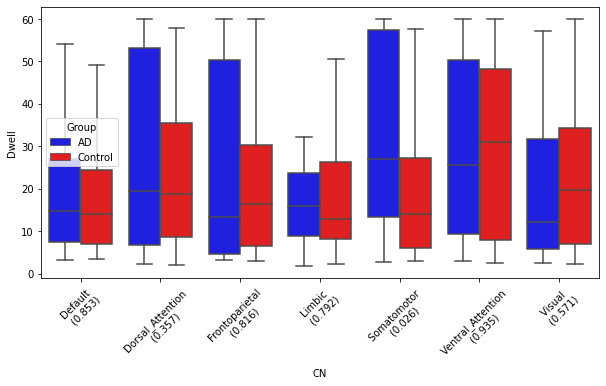

In [100]:
# dwell time for each CN with label by max parameter
curDNLAD = []
curDNLCtrl = []
curDwell = []

for ix in range(len(fsAD)):
    curDwellCt = ddict(float)
    curFs = fsAD[ix]
    curMlabs = []
    for ixx in range(curFs.wUAll.shape[1]):
        curY = curFs.wUAll[:, ixx]
        curOLS = sm.OLS(curY, fcRarr.T )
        curOLSfit = curOLS.fit()
        curMlabs.append(np.array(rowNames)[np.abs(curOLSfit.params).argmax()])
    for ixx, curMlab in enumerate(curMlabs):
        curDwellCt[curMlab] += curFs.dwell[ixx]
    allIts = list(curDwellCt.items())
    curDwell = curDwell + [ixxx[1] for ixxx in allIts]
    curDNLAD = curDNLAD + [ixxx[0] for ixxx in allIts]
    
for ix in range(len(fsCtrl)):
    curDwellCt = ddict(float)
    curFs = fsCtrl[ix]
    curMlabs = []
    for ixx in range(curFs.wUAll.shape[1]):
        curY = curFs.wUAll[:, ixx]
        curOLS = sm.OLS(curY, fcRarr.T )
        curOLSfit = curOLS.fit()
        curMlabs.append(np.array(rowNames)[np.abs(curOLSfit.params).argmax()])
    for ixx, curMlab in enumerate(curMlabs):
        curDwellCt[curMlab] += curFs.dwell[ixx]
    allIts = list(curDwellCt.items())
    curDwell = curDwell + [ixxx[1] for ixxx in allIts]
    curDNLCtrl = curDNLCtrl + [ixxx[0] for ixxx in allIts]
    
# below do not consider a subject have multiple segment for same label
# for ix in range(len(fsAD)):
#     curDwell = curDwell + list(fsAD[ix].dwell)
#     curFs = fsAD[ix]
#     for ixx in range(curFs.wUAll.shape[1]):
#         curY = curFs.wUAll[:, ixx]
#         curOLS = sm.OLS(curY, fcRarr.T )
#         curOLSfit = curOLS.fit()
#         curDNLAD.append(np.array(rowNames)[np.abs(curOLSfit.params).argmax()])
#     
# for ix in range(len(fsCtrl)):
#     curDwell = curDwell + list(fsCtrl[ix].dwell)
#     curFs = fsCtrl[ix]
#     for ixx in range(curFs.wUAll.shape[1]):
#         curY = curFs.wUAll[:, ixx]
#         curOLS = sm.OLS(curY, fcRarr.T )
#         curOLSfit = curOLS.fit()
#         curDNLCtrl.append(np.array(rowNames)[np.abs(curOLSfit.params).argmax()])
    
    
dwellDF = pd.DataFrame({"Dwell": curDwell, "CN": curDNLAD+curDNLCtrl, 
                        "Group": ["AD"]*len(curDNLAD) + ["Control"]*len(curDNLCtrl)})

xticklabs = []
for nam in rowNames:
    curSubAD = dwellDF[(dwellDF["CN"] == nam) & (dwellDF["Group"] == "AD")]
    curSubCtrl = dwellDF[(dwellDF["CN"] == nam) & (dwellDF["Group"] == "Control")]
    restt = scipy.stats.ttest_ind(curSubAD["Dwell"], curSubCtrl["Dwell"], equal_var=True)
    resrs = scipy.stats.ranksums(curSubAD["Dwell"], curSubCtrl["Dwell"])
    resks = scipy.stats.kstest(curSubAD["Dwell"], curSubCtrl["Dwell"])
    xticklabs.append(f"{nam} \n ({restt.pvalue:.3f})")
    
plt.figure(figsize=[10, 5])
sns.boxplot(x="CN", y="Dwell", hue="Group", data=dwellDF, showfliers=False, palette = {"AD":'blue', "Control":'red'}, order=rowNames)
plt.xticks(np.arange(7), xticklabs)
_ = plt.xticks(rotation=45)

### Imag part of eigen value (not used)

In [101]:
eigValImagAD = []
for ix in range(len(eigValsAD)):
    eigValImagAD.append(np.concatenate([list(tVal.imag) for tVal in eigValsAD[ix]]))
eigValImagAD = np.abs(np.concatenate(eigValImagAD))

eigValImagCtrl = []
for ix in range(len(eigValsCtrl)):
    eigValImagCtrl.append(np.concatenate([list(tVal.imag) for tVal in eigValsCtrl[ix]]))
eigValImagCtrl = np.abs(np.concatenate(eigValImagCtrl))

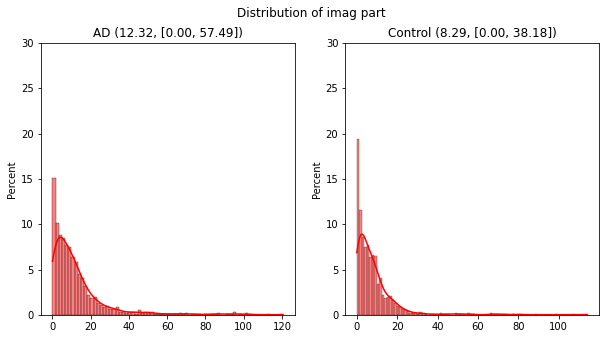

In [102]:
plt.figure(figsize=[10, 5])
plt.suptitle("Distribution of imag part")
plt.subplot(121)
plt.title(f"AD ({np.mean(eigValImagAD):.2f}, [{np.quantile(eigValImagAD, 0.025):.2f}, {np.quantile(eigValImagAD, 0.975):.2f}])")
sns.histplot(eigValImagAD, stat="percent", kde=1, color="red")
plt.xlabel("")
plt.ylim([0, 30])

plt.subplot(122)
plt.title(f"Control ({np.mean(eigValImagCtrl):.2f}, [{np.quantile(eigValImagCtrl, 0.025):.2f}, {np.quantile(eigValImagCtrl, 0.975):.2f}])")
sns.histplot(eigValImagCtrl, stat="percent", kde=1, color="red")
plt.ylim([0, 30])
plt.xlabel("")

#plt.savefig("./plots/eigValAbsImagDist.jpg", bbox_inches='tight')

In [103]:
restt = scipy.stats.ttest_ind(eigValImagAD, eigValImagCtrl)
resrs = scipy.stats.ranksums(eigValImagAD, eigValImagCtrl)
resks = scipy.stats.kstest(eigValImagAD, eigValImagCtrl)
print(
    f"The pvalue of t test is {restt.pvalue:.4f}, "
    f"The pvalue of rank sum test is {resrs.pvalue:.4f}, "
    f"The pvalue of ks test is {resks.pvalue:.4f}."
     )

The pvalue of t test is 0.0000, The pvalue of rank sum test is 0.0000, The pvalue of ks test is 0.0000.


## SubType analysis for AD

In [31]:
from scipy.stats import chi2_contingency
from sklearn.metrics import classification_report, f1_score, confusion_matrix

### Get Subtype labs for AD data

In [33]:
RID_AD_labs = loadmat("./OtherFils/RID_AD.mat")["radid"].reshape(-1)
labs = [lab[0].split("A")[0] for lab in RID_AD_labs]
labMap = np.array(pd.read_excel('./OtherFils/ADlist_80_with_labels.xlsx'))

In [34]:
subTypLabs = []
for lab in labs:
    idx = (labMap == lab).sum(axis=1, dtype=bool)
    if idx.sum() != 0:
        subTypLabs.append(labMap[idx, -1][0])
    else:
        subTypLabs.append("NULL")
# Last dataset 
subTypLabs.append("NULL")
subTypLabs = np.array(subTypLabs)

In [35]:
subTypLabsC = subTypLabs[subTypLabs!="NULL"]

###  Regression 

#### Logi model with ridge

class the three types

In [110]:
penalty = "l2"
fsName = ["r", "ncpts", "wUmeanAll"]
cFAD = []
for fName in fsName:
    if isinstance(fsAD[0][fName], numbers.Number):
        cfAD = np.array([fs[fName] for fs in fsAD]).reshape(-1, 1)
    else:
        cfAD = np.array([fs[fName] for fs in fsAD])
    
    cFAD.append(cfAD)
cFAD = np.concatenate(cFAD, axis=1)
cFAD = cFAD[subTypLabs!="NULL"]
cFADstd = (cFAD- cFAD.mean(axis=0))/cFAD.std(axis=0)

In [111]:
Cs = [0.1, 0.2, 0.4, 0.8, 1, 1.6, 3.2, 6.4]
f1s = []
for C in Cs:
    eProbs = []
    loo = LeaveOneOut()
    for trIdxs, testIdxs in loo.split(cFADstd):
        clf = LogisticRegression(penalty=penalty, random_state=0, C=C)
        clf.fit(cFADstd[trIdxs, :], subTypLabsC[trIdxs])
        eProbs.append(clf.predict_proba(cFADstd[testIdxs, :]))
    eProbs = np.array(eProbs).squeeze()
    elabs = clf.classes_[eProbs.argmax(axis=1)]
    f1 = f1_score(subTypLabsC, elabs, average="weighted")
    f1s.append(f1)

In [112]:
optC = Cs[np.argmax(f1s)]
eProbs = []
loo = LeaveOneOut()
for trIdxs, testIdxs in loo.split(cFADstd):
    clf = LogisticRegression(penalty=penalty, random_state=0, C=optC)
    clf.fit(cFADstd[trIdxs, :], subTypLabsC[trIdxs])
    eProbs.append(clf.predict_proba(cFADstd[testIdxs, :]))
eProbs = np.array(eProbs).squeeze()
elabs = clf.classes_[eProbs.argmax(axis=1)]
f1 = f1_score(subTypLabsC, elabs, average="weighted")
print(classification_report(subTypLabsC, elabs))
pd.crosstab(subTypLabsC, elabs)

              precision    recall  f1-score   support

      AD-LPA       0.43      0.21      0.29        14
      AD-MEM       0.66      0.82      0.73        50
      AD-PCA       0.10      0.07      0.08        15

    accuracy                           0.57        79
   macro avg       0.40      0.37      0.37        79
weighted avg       0.51      0.57      0.53        79



col_0,AD-LPA,AD-MEM,AD-PCA
row_0,,,
AD-LPA,3,8,3
AD-MEM,3,41,6
AD-PCA,1,13,1


####  Regression on each feature (not used)

Let `AD-MEM` as ref class

Y = each fs
X = three classes

Text(0.5, 1.0, 'Linear Reg R-squared')

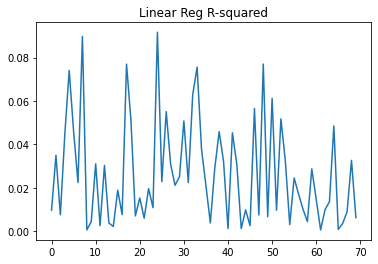

In [113]:
cX =  pd.get_dummies(subTypLabsC, drop_first=False).loc[:, ["AD-PCA", "AD-LPA"]]
#cX =  pd.get_dummies(subTypLabsC, drop_first=True)
Rvs = []
pvs = []
fpvs = []
for j in range(cFADstd.shape[-1]):
    cY = cFADstd[:, j]
    #cMd = sm.OLS(cY, cX)
    cMd = sm.OLS(cY, sm.add_constant(cX))
    cMdres = cMd.fit()
    Rvs.append(cMdres.rsquared)
    pvs.append(cMdres.pvalues)
    fpvs.append(cMdres.f_pvalue)
    
Rvs  = np.array(Rvs)
pvs  = np.array(pvs)
fpvs  = np.array(fpvs)
plt.plot(Rvs)
plt.title("Linear Reg R-squared")

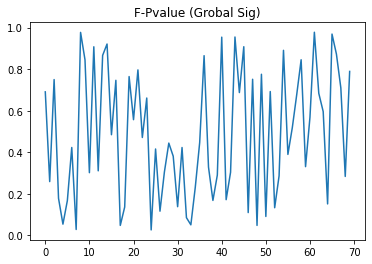

In [117]:
plt.title("F-Pvalue (Grobal Sig)")
plt.plot(fpvs)

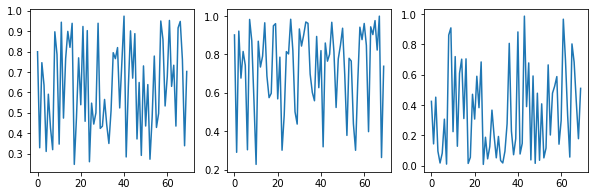

In [118]:
plt.figure(figsize=[10, 3])
plt.subplot(131)
plt.plot(pvs[:, 0])
plt.subplot(132)
plt.plot(pvs[:, 1])
plt.subplot(133)
plt.plot(pvs[:, 2])

In [119]:
# sig variable under pvs
selFs = xlabs[fpvs < 0.05]
selPs = fpvs[fpvs < 0.05]
# for selF in selFs:
#      if selF in xlabs[kpidxId]:
#             print(selF)
preFixSubtype = "_".join(fsName)
fSel = np.zeros(68)
fSel[fpvs[2:] < 0.05] = 1
outFSel = U2BrainVec(reorderU(fSel))
#np.savetxt(f"./brainPlotFils/{preFixSubtype}_SubType_Fsel.txt", outFSel)
print("Overall")
pd.DataFrame([selFs, selPs])

Overall


,0,1,2,3
0,L-Frontalpole,L-Middletemporal,L-Postcentral,R-Lateralorbitofrontal
1,0.028,0.048,0.026,0.048


In [120]:
tmpIdx = 0
# sig variable under pvs
selFs = xlabs[pvs[:, tmpIdx] < 0.05]
selPs = pvs[:, tmpIdx][pvs[:, tmpIdx] < 0.05]
# for selF in selFs:
#      if selF in xlabs[kpidxId]:
#             print(selF)
lpaSel = np.zeros(68)
lpaSel[pvs[2:, tmpIdx] < 0.05] = 1
outLPASel = U2BrainVec(reorderU(lpaSel))
#np.savetxt(f"./brainPlotFils/{preFixSubtype}_SubType_LPAsel.txt", outLPASel)

print("Intercept")
pd.DataFrame([selFs, selPs])

Intercept


""
0
1


In [121]:
tmpIdx = 1
# sig variable under pvs
selFs = xlabs[pvs[:, tmpIdx] < 0.05]
selPs = pvs[:, tmpIdx][pvs[:, tmpIdx] < 0.05]
# for selF in selFs:
#      if selF in xlabs[kpidxId]:
#             print(selF)
print(cX.columns[tmpIdx-1])
pd.DataFrame([selFs, selPs])

AD-PCA


""
0
1


In [122]:
tmpIdx = 2
# sig variable under pvs
selFs = xlabs[pvs[:, tmpIdx] < 0.05]
selPs = pvs[:, tmpIdx][pvs[:, tmpIdx] < 0.05]
# for selF in selFs:
#      if selF in xlabs[kpidxId]:
#             print(selF)
print(cX.columns[tmpIdx-1])
print(pd.DataFrame({"Feature": selFs, "Pvalue": selPs}))

AD-LPA
                  Feature  Pvalue
0   L-Caudalmiddlefrontal   0.017
1           L-Frontalpole   0.009
2        L-Middletemporal   0.014
3           L-Postcentral   0.008
4            L-Precentral   0.044
5      L-Superiortemporal   0.033
6         L-Supramarginal   0.017
7      R-Isthmuscingulate   0.037
8  R-Lateralorbitofrontal   0.014
9   R-Medialorbitofrontal   0.035


### Clustering on subtype (not used)

In [123]:
fsName = ["r", "ncpts", "wUmeanAll"]
cFAD = []
for fName in fsName:
    if isinstance(fsAD[0][fName], numbers.Number):
        cfAD = np.array([fs[fName] for fs in fsAD]).reshape(-1, 1)
    else:
        cfAD = np.array([fs[fName] for fs in fsAD])
    
    cFAD.append(cfAD)
cFAD = np.concatenate(cFAD, axis=1)
cFAD = cFAD[subTypLabs!="NULL"]
cFADstd = (cFAD- cFAD.mean(axis=0))/cFAD.std(axis=0)


clu = KMeans(n_clusters=3, random_state=0).fit(cFADstd)
#clu= SpectralClustering(n_clusters=3, random_state=0).fit(cFADstd)
elabs =clu.labels_
tlabs = subTypLabsC

conTB = np.array(pd.crosstab(elabs, tlabs))
chi2, pv, _, _ = chi2_contingency(conTB)
pStr = f"The chisq stat is {chi2:.3f}, the pvalue of the test is {pv:.3f}."
print(pStr)
pd.crosstab(elabs, tlabs)

The chisq stat is 5.488, the pvalue of the test is 0.241.


col_0,AD-LPA,AD-MEM,AD-PCA
row_0,,,
0,11,46,13
1,2,4,2
2,1,0,0


###  Combine `AD-LPA` and `AD-PCA` (not used)

In [125]:
twoLabs = subTypLabsC.copy()
twoLabs[subTypLabsC!="AD-MEM"] = 0
twoLabs[subTypLabsC=="AD-MEM"] = 1
twoLabs = twoLabs.astype(float)

In [126]:
penalty = "l2"
fsName = ["r", "ncpts", "wUmeanAll"]
cFAD = []
for fName in fsName:
    if isinstance(fsAD[0][fName], numbers.Number):
        cfAD = np.array([fs[fName] for fs in fsAD]).reshape(-1, 1)
    else:
        cfAD = np.array([fs[fName] for fs in fsAD])
    
    cFAD.append(cfAD)
cFAD = np.concatenate(cFAD, axis=1)
cFAD = cFAD[subTypLabs!="NULL"]
cFADstd = (cFAD- cFAD.mean(axis=0))/cFAD.std(axis=0)
#cFADstd = cFADstd[:, kpidxId]

Text(0, 0.5, 'AUC')

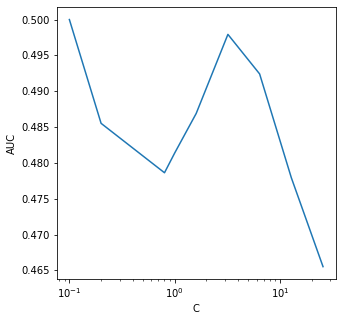

In [127]:
Cs = [0.1, 0.2, 0.4, 0.8, 1, 1.6, 3.2, 6.4, 12.8, 25.6]
aucCs = []
for C in Cs:
    eProbs = []
    loo = LeaveOneOut()
    for trIdxs, testIdxs in loo.split(cFADstd):
        clf = LogisticRegression(penalty=penalty, random_state=0, C=C)
        clf.fit(cFADstd[trIdxs, :], twoLabs[trIdxs])
        eProbs.append(clf.predict_proba(cFADstd[testIdxs, :]))
    eProbs = np.array(eProbs).squeeze()
    elabs = clf.classes_[eProbs.argmax(axis=1)]
    auc = roc_auc_score(twoLabs, eProbs[:, 1])
    aucCs.append(auc)
    

    
plt.figure(figsize=[5, 5])
plt.plot(Cs, aucCs)
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("AUC")

In [128]:
optC = Cs[np.argmax(aucCs)]
eProbs = []
loo = LeaveOneOut()
parass = []
for trIdxs, testIdxs in loo.split(cFADstd):
    clf = LogisticRegression(penalty=penalty, random_state=0, C=optC)
    clf.fit(cFADstd[trIdxs, :], twoLabs[trIdxs])
    paras = clf.coef_.reshape(-1)
    parass.append(paras)
    eProbs.append(clf.predict_proba(cFADstd[testIdxs, :]))
eProbs = np.array(eProbs).squeeze()
auc = roc_auc_score(twoLabs, eProbs[:, 1])
fpr, tpr, thresholds = roc_curve(twoLabs, eProbs[:, 1], pos_label=1)
parass = np.array(parass)
print(auc)

0.5


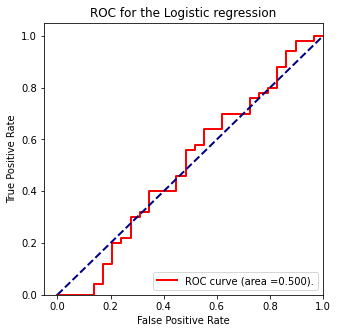

In [129]:
plt.figure(figsize=[5, 5])
plt.plot(fpr, tpr, label=f"ROC curve (area ={auc:.3f}).", lw=2, color="red")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for the Logistic regression")
plt.legend(loc="lower right")

### Subtype vs control

In [36]:
penalty = "l2"
fsName = ["r", "ncpts", "wUmeanAll"]
XsAD = []
XsCtrl = []
for fName in fsName:
    if isinstance(fsAD[0][fName], numbers.Number):
        cfAD = np.array([fs[fName] for fs in fsAD]).reshape(-1, 1)
        cfCtrl = np.array([fs[fName] for fs in fsCtrl]).reshape(-1, 1)
    else:
        cfAD = np.array([fs[fName] for fs in fsAD])
        cfCtrl = np.array([fs[fName] for fs in fsCtrl])
    
    XsAD.append(cfAD)
    XsCtrl.append(cfCtrl)


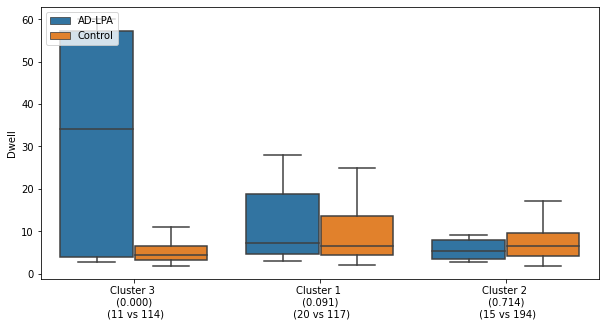

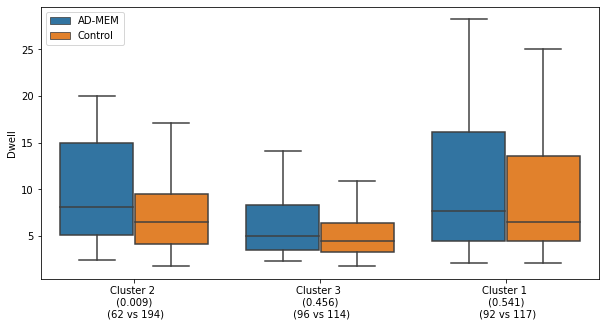

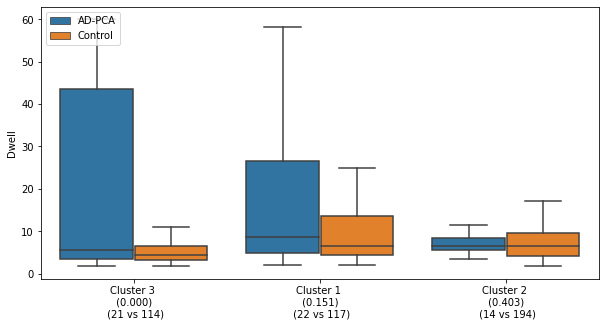

In [131]:
# KM 

wUsubLabs = []
flag = 0
curElabs = elabsKMused
for ix in range(len(fsAD)):
    nds = len(fsAD[ix].dwell)
    wUsubLabs = wUsubLabs + [subTypLabs[ix]]*nds

cluDFKMsub  = pd.DataFrame({"Dwell": dwellAll, "elabs": elabsKMused, 
                         "Group":wUsubLabs+["Control"]*len(dwellCtrlAll)})
#cluDFKMsub = cluDFKMsub[cluDFKMsub["Group"]!="NULL"]



for curSubTyp in ["AD-LPA", "AD-MEM", "AD-PCA"]:
    curXticklabsSubKM = []
    curPvsSubKM = []
    for ix in range(np.max(elabsKMused)+1):
        curAD = cluDFKMsub[(cluDFKMsub["elabs"]==ix) & (cluDFKMsub["Group"]==curSubTyp)]
        curCtrl = cluDFKMsub[(cluDFKMsub["elabs"]==ix) & (cluDFKMsub["Group"]=="Control")]
        restt = scipy.stats.ttest_ind(curAD["Dwell"], curCtrl["Dwell"])
        pv = restt.pvalue
        curPvsSubKM.append(pv)
        curXticklabsSubKM.append(f"Cluster {ix+1} \n ({pv:.3f}) \n ({len(curAD)} vs {len(curCtrl)})")
        
    plt.figure(figsize=[10, 5])
    #plt.title("Kmeans")
    sns.boxplot(x="elabs", y="Dwell", hue="Group", data=cluDFKMsub[(cluDFKMsub["Group"]==curSubTyp) |(cluDFKMsub["Group"]=="Control")], 
                showfliers=False, order=np.argsort(curPvsSubKM))
    plt.xlabel("")
    plt.legend(loc="upper left")
    _ = plt.xticks(np.arange(np.max(elabsKMused)+1), np.array(curXticklabsSubKM)[np.argsort(curPvsSubKM)])
    plt.savefig(f"./plots/boxplot_wUKmeans_{nclu}_{curSubTyp}.jpg", bbox_inches='tight')    

In [37]:
np.random.seed(0)
for cSubTyp in ["AD-MEM", "AD-PCA", "AD-LPA"]:
    print(cSubTyp)
    cYs = np.concatenate([np.ones(np.sum(subTypLabs==cSubTyp)), np.zeros(len(fsCtrl))])
    cXsAD = np.concatenate(XsAD, axis=1)[subTypLabs==cSubTyp, :]
    cXsCtrl = np.concatenate(XsCtrl, axis=1)
    cXs = np.concatenate([cXsAD, cXsCtrl], axis=0)
    cStdXs = (cXs - cXs.mean(axis=0))/cXs.std(axis=0)
    
    
    Cs = [0.1, 0.2, 0.4, 0.8, 1, 1.6, 3.2, 6.4]
    aucCs = []
    for C in Cs:
        eProbs = []
        loo = LeaveOneOut()
        for trIdxs, testIdxs in loo.split(cStdXs):
            clf = LogisticRegression(penalty=penalty, random_state=0, C=C)
            clf.fit(cStdXs[trIdxs, :], cYs[trIdxs])
            eProbs.append(clf.predict_proba(cStdXs[testIdxs, :]))
        eProbs = np.array(eProbs).squeeze()
        auc = roc_auc_score(cYs, eProbs[:, 1])
        fpr, tpr, thresholds = roc_curve(cYs, eProbs[:, 1], pos_label=1)
        aucCs.append(auc)
        
    # plt.figure(figsize=[5, 5])
    # plt.plot(Cs, aucCs)
    # plt.xscale("log")
    # plt.xlabel("C")
    # plt.ylabel("AUC")
    # 
    optC = Cs[np.argmax(aucCs)]
    eProbs = []
    loo = LeaveOneOut()
    cParass = []
    for trIdxs, testIdxs in loo.split(cStdXs):
        #clf = GBC(n_estimators=50, random_state=0, max_depth=2, learning_rate=0.1)
        clf = LogisticRegression(penalty=penalty, random_state=0, C=optC)
        clf.fit(cStdXs[trIdxs, :], cYs[trIdxs])
        paras = clf.coef_.reshape(-1)
        cParass.append(paras)
        eProbs.append(clf.predict_proba(cStdXs[testIdxs, :]))
    eProbs = np.array(eProbs).squeeze()
    auc = roc_auc_score(cYs, eProbs[:, 1])
    fpr, tpr, thresholds = roc_curve(cYs, eProbs[:, 1], pos_label=1)
    cParass = np.array(cParass)
    print(auc)
    
    # nobs = cStdXs.shape[0]
    # Aucss = []
    # for j in range(1000):
    #     testIdx = np.random.choice(nobs, int(nobs/5), False)
    #     trainIdx = np.delete(np.arange(nobs), testIdx)
    #     clf = LogisticRegression(penalty=penalty, random_state=0, C=optC)
    #     clf.fit(cStdXs[trainIdx], cYs[trainIdx])
    #     curEprobs = clf.predict_proba(cStdXs[testIdx, :])
    #     curAuc = roc_auc_score(cYs[testIdx], curEprobs[:, 1])
    #     Aucss.append(curAuc)
    # mAUC = np.mean(Aucss)
    # stdAUC = np.std(Aucss)
    # print(f"The mean of AUC under 1000 repetitions is {mAUC:.3f} and the standard deviation is {stdAUC:.3f}.")
    
    # plt.figure(figsize=[5, 5])
    # plt.plot(fpr, tpr, label=f"ROC curve (area ={auc:.3f}).", lw=2, color="red")
    # plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    # plt.xlim([-0.05, 1.0])
    # plt.ylim([0.0, 1.05])
    # plt.xlabel("False Positive Rate")
    # plt.ylabel("True Positive Rate")
    # plt.title("ROC for the Logistic regression")
    # plt.legend(loc="lower right")
    repTime = 10000
    cParassBoot = []
    for i in range(repTime):
        bootIdx = np.random.choice(len(cYs), len(cYs))
        YsBoot = cYs[bootIdx]
        stdXsBoot = cStdXs[bootIdx]
        clf = LogisticRegression(penalty=penalty, random_state=0, C=optC)
        clf.fit(stdXsBoot, YsBoot)
        parasBoot = clf.coef_.reshape(-1)
        cParassBoot.append(parasBoot)
        
    cParassBoot = np.array(cParassBoot)
    lows, ups = np.quantile(cParassBoot[:, :], [0.025, 0.975], axis=0)
    cKpidxBoot = np.bitwise_or(lows >0,  ups < 0)
    cKpidxIdBoot = np.where(cKpidxBoot)[0]
    print(", ".join(xlabs[cKpidxBoot]))
    
    
    repTime = 10000
    cParassPerm = []
    for i in range(repTime):
        cYsPerm = np.random.permutation(cYs)
        clf = LogisticRegression(penalty=penalty, random_state=0, C=optC)
        clf.fit(cStdXs, cYsPerm)
        parasPerm= clf.coef_.reshape(-1)
        cParassPerm.append(parasPerm)
        
    cParassPerm = np.array(cParassPerm)
    
    curClfFinal = LogisticRegression(penalty=penalty, random_state=0, C=optC)
    curClfFinal.fit(cStdXs, cYs)
    curCoefsFinal = curClfFinal.coef_.reshape(-1)
    
    #cPvals = (np.abs(cParassPerm) > np.abs(curCoefsFinal)).mean(axis=0)
    cPvals = np.array([(cParassPerm > curCoefsFinal).mean(axis=0), (cParassPerm < curCoefsFinal).mean(axis=0)]).min(axis=0)
    resDic = {
       "Feature" : xlabs,  
        "Parameters": curCoefsFinal,
        "Lower": lows,
        "Upper": ups,
        "Pvalues": cPvals
    }
    pd.set_option("display.precision", 3)
    curResDF = pd.DataFrame(resDic)
    print(curResDF)
    
    # The selected ROIs by after selection, by CI
    selVec = (cKpidxBoot[2:]).astype(np.int)
    outSelVec = U2BrainVec(reorderU(selVec))
    np.savetxt(f"./brainPlotFils/{preFix}_{cSubTyp}_SelVecBoot.txt", outSelVec)
    pd.DataFrame({"Name": regionNames, "Vec": selVec}).to_csv(f"./brainPlotFils/{preFix}_{cSubTyp}_SelVecBoot.csv", index=False)
    
    # The selected ROIs by after selection, by pvals
    selVec = (cPvals[2:]<=0.05).astype(np.int)
    outSelVec = U2BrainVec(reorderU(selVec))
    np.savetxt(f"./brainPlotFils/{preFix}_{cSubTyp}_SelVecPval.txt", outSelVec)
    pd.DataFrame({"Name": regionNames, "Vec": selVec}).to_csv(f"./brainPlotFils/{preFix}_{cSubTyp}_SelVecPval.csv", index=False)
    
    # Estimate parameters
    outSelVec = U2BrainVec(reorderU(minmax(np.abs(curCoefsFinal[2:]))))
    np.savetxt(f"./brainPlotFils/{preFix}_{cSubTyp}_Paras.txt", outSelVec)
    pd.DataFrame({"Name": regionNames, "Vec": minmax(np.abs(curCoefsFinal[2:]))}).to_csv(f"./brainPlotFils/{preFix}_{cSubTyp}_Paras.csv", index=False)

AD-MEM
0.7605714285714287
Rank, Num of cpts, L-Cuneus, L-Fusiform, L-Inferiorparietal, L-Lingual, L-Postcentral, L-Rostralanteriorcingulate, L-Superiortemporal, R-Cuneus, R-Inferiortemporal, R-Isthmuscingulate, R-Pericalcarine
                      Feature  Parameters  Lower  Upper  Pvalues
0                        Rank       0.976  0.090  1.659    0.013
1                 Num of cpts      -0.508 -1.009 -0.095    0.021
2                  L-Bankssts      -0.419 -0.826  0.184    0.153
3   L-Caudalanteriorcingulate       0.046 -0.481  0.680    0.450
4       L-Caudalmiddlefrontal       0.162 -0.544  0.719    0.372
..                        ...         ...    ...    ...      ...
65         R-Superiorparietal       0.072 -0.494  0.604    0.428
66         R-Superiortemporal       0.251 -0.146  0.662    0.225
67            R-Supramarginal       0.056 -0.497  0.583    0.435
68             R-Temporalpole       0.271 -0.346  0.857    0.266
69       R-Transversetemporal       0.003 -0.572  0.751   

## Analyze the freq of Xmat after smoothing

In [68]:
ADfreqRaw = loadmat(list(resDir.glob("*ADPower.mat"))[0])["psAD"][0, 0]
CtrlfreqRaw = loadmat(list(resDir.glob("*CtrlPower.mat"))[0])["psCtrl"][0, 0]

In [117]:
freqs = ADfreqRaw[0][0, 0][1].reshape(-1)
ADfreqs = [ADfreq[0, 0][0] for ADfreq in ADfreqRaw]
Ctrlfreqs = [Ctrlfreq[0, 0][0] for Ctrlfreq in CtrlfreqRaw]
ADfreqs = [ADfreq[0, 0][0]/np.sum(ADfreq[0, 0][0], axis=0) for ADfreq in ADfreqRaw]
Ctrlfreqs = [Ctrlfreq[0, 0][0]/np.sum(Ctrlfreq[0, 0][0], axis=0) for Ctrlfreq in CtrlfreqRaw]

In [118]:
ADfreqsAll = np.concatenate(ADfreqs, axis=1)
CtrlfreqsAll = np.concatenate(Ctrlfreqs, axis=1)

In [119]:
ADfreqlows, ADfrequps  = np.quantile(ADfreqsAll[:, :], [0.025, 0.975], axis=1)
ADfreqMean = np.mean(ADfreqsAll, axis=1)
Ctrlfreqlows, Ctrlfrequps  = np.quantile(CtrlfreqsAll[:, :], [0.025, 0.975], axis=1)
CtrlfreqMean = np.mean(CtrlfreqsAll, axis=1)

Text(0.5, 0, 'Frequency (Hz)')

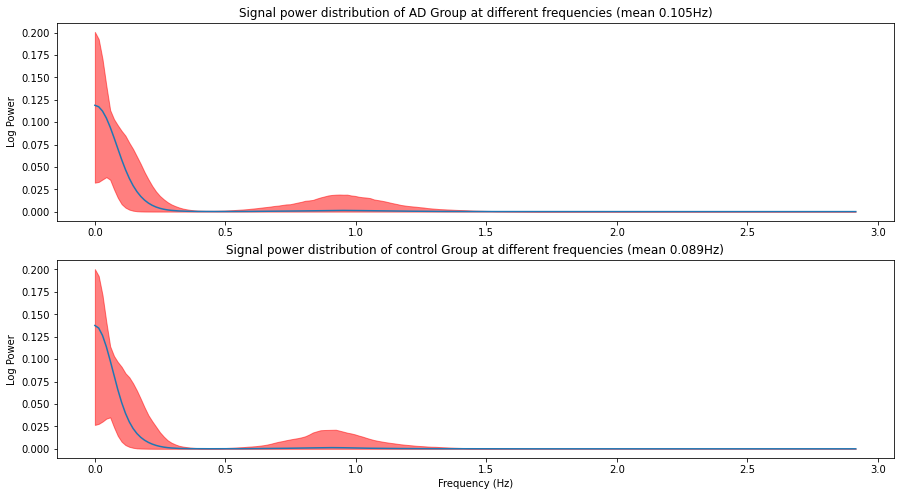

In [134]:
uplim = 200
plt.figure(figsize=[15, 8])
plt.subplot(211)
plt.fill_between(freqs[:uplim], ADfreqlows[:uplim], ADfrequps[:uplim], color="red", alpha=.5)
plt.plot(freqs[:uplim], ADfreqMean[:uplim])
#plt.yscale("log")
plt.title(f"Signal power distribution of AD Group at different frequencies (mean {np.sum(ADfreqMean*freqs):.3f}Hz)")
plt.ylabel("Log Power")
#plt.xlabel("Frequency (Hz)")


plt.subplot(212)
plt.fill_between(freqs[:uplim], Ctrlfreqlows[:uplim], Ctrlfrequps[:uplim], color="red", alpha=.5)
plt.plot(freqs[:uplim], CtrlfreqMean[:uplim])
#plt.yscale("log")
plt.title(f"Signal power distribution of control Group at different frequencies (mean {np.sum(CtrlfreqMean*freqs):.3f}Hz)")
plt.ylabel("Log Power")
plt.xlabel("Frequency (Hz)")
#plt.savefig(f"./plots/{preFix}_penaltySelBoot.jpg", bbox_inches='tight')

## Select features analysis (not formal)

In [79]:
clu = KMeans(n_clusters=2, random_state=0).fit(stdXs[:, :2])
#clu= SpectralClustering(n_clusters=2, random_state=0).fit(vecsAll)
elabs =clu.labels_
tlabs = Ys
tb = np.array([[np.sum(elabs[tlabs==0]), np.sum(elabs[tlabs==1])],  
               [np.sum(1-elabs[tlabs==0]), np.sum(1-elabs[tlabs==1])]])
conTb = pTB()
conTb.field_names = [" ", "Ctrl", "AD"]
conTb.add_row(["label 0", tb[0, 0], tb[0, 1]]) 
conTb.add_row(["label 1", tb[1, 0], tb[1, 1]]) 
OR, pv = fisher_exact(tb)
pStr = f"The odds ratio between control and AD groups is {OR:.3f}, the pvalue of the fisher exact test is {pv:.3f}."
print(pStr)
print(conTb)

The odds ratio between control and AD groups is 0.600, the pvalue of the fisher exact test is 0.424.
+---------+------+----+
|         | Ctrl | AD |
+---------+------+----+
| label 0 |  5   | 10 |
| label 1 |  65  | 78 |
+---------+------+----+


0.717391304347826

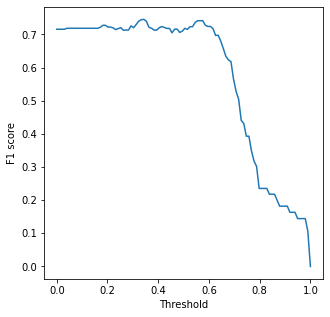

In [80]:
thres = np.linspace(0, 1, 100)
f1s = []
for thre in thres:
    f1s.append(f1_score(Ys, eProbs[:, 1]>thre))
    
plt.figure(figsize=[5, 5])
plt.plot(thres, f1s)
plt.xlabel("Threshold")
plt.ylabel("F1 score")

optThre = thres[np.argmax(f1s)]
optThre = 0.5
f1_score(Ys, eProbs[:, 1]>optThre)

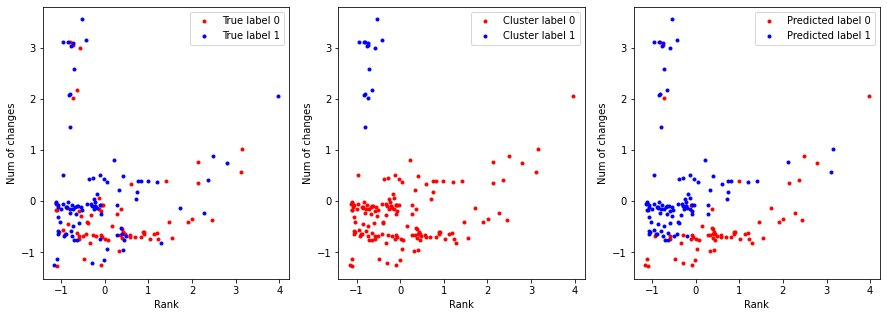

In [81]:
eProbs1 = eProbs[:, 1]
js1 = np.abs(stdXs[:, 0]).mean()/10 * np.random.randn(stdXs.shape[0])
js2 = np.abs(stdXs[:, 1]).mean()/10 * np.random.randn(stdXs.shape[0])
stdRks = stdXs[:, 0] + js1
stdNcpts = stdXs[:, 1] + js2
plt.figure(figsize=[15, 5])
plt.subplot(131)
plt.plot(stdRks[Ys==0], stdNcpts[Ys==0], "r.", label="True label 0")
plt.plot(stdRks[Ys==1], stdNcpts[Ys==1], "b.", label="True label 1")
plt.xlabel("Rank")
plt.ylabel("Num of changes")
plt.legend()

plt.subplot(132)
plt.plot(stdRks[elabs==0], stdNcpts[elabs==0], "r.", label="Cluster label 0")
plt.plot(stdRks[elabs==1], stdNcpts[elabs==1], "b.", label="Cluster label 1")
plt.xlabel("Rank")
plt.ylabel("Num of changes")
plt.legend()

plt.subplot(133)
plt.plot(stdRks[eProbs1<=optThre], stdNcpts[eProbs1<=optThre], "r.", label="Predicted label 0")
plt.plot(stdRks[eProbs1>optThre], stdNcpts[eProbs1>optThre], "b.", label="Predicted label 1")
plt.xlabel("Rank")
plt.ylabel("Num of changes")
plt.legend()
plt.savefig("./plots/rkNcptsCluster.jpg", bbox_inches='tight')

In [82]:
sigIdxs = kpidxId[mdres.pvalues <0.05]
clu = KMeans(n_clusters=2, random_state=0).fit(stdXs[:, kpidxId])
clu= SpectralClustering(n_clusters=2, random_state=1).fit(stdXs[:, kpidxId])
#clu= SpectralClustering(n_clusters=2, random_state=1).fit(stdXs[:, sigIdxs])
elabs =clu.labels_
tlabs = Ys
tb = np.array([[np.sum(elabs[tlabs==0]), np.sum(elabs[tlabs==1])],  
               [np.sum(1-elabs[tlabs==0]), np.sum(1-elabs[tlabs==1])]])
conTb = pTB()
conTb.field_names = [" ", "Ctrl", "AD"]
conTb.add_row(["label 0", tb[0, 0], tb[0, 1]]) 
conTb.add_row(["label 1", tb[1, 0], tb[1, 1]]) 
OR, pv = fisher_exact(tb)
pStr = f"The odds ratio between control and AD groups is {OR:.3f}, the pvalue of the fisher exact test is {pv:.3f}."
print(pStr)
print(conTb)

The odds ratio between control and AD groups is 2.559, the pvalue of the fisher exact test is 0.585.
+---------+------+----+
|         | Ctrl | AD |
+---------+------+----+
| label 0 |  2   | 1  |
| label 1 |  68  | 87 |
+---------+------+----+


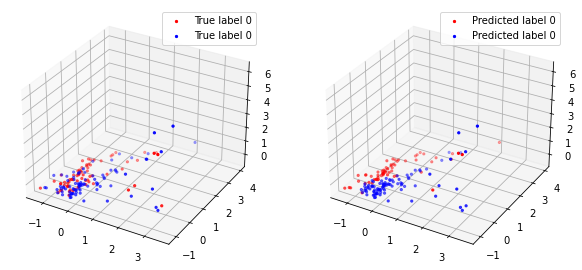

In [65]:
ft1 = stdXs[:, sigIdxs][:, 0] +js1
ft2 = stdXs[:, sigIdxs][:, 1] + js2
ft3 = stdXs[:, sigIdxs][:, -1]

fig = plt.figure(figsize=[10, 5])
ax1 = fig.add_subplot(121, projection="3d")
ax1.scatter(ft1[Ys==0], ft2[Ys==0], ft3[Ys==0], color="red", marker='.', label="True label 0")
ax1.scatter(ft1[Ys==1], ft2[Ys==1], ft3[Ys==1], color="blue", marker='.', label="True label 0")
plt.legend()
#ax1.set_zlim([0, 1])

# ax2 = fig.add_subplot(132, projection="3d")
# ax2.scatter(ft1[elabs==0], ft2[elabs==0], ft3[elabs==0], color="red", marker='.', label="Cluster label 0")
# ax2.scatter(ft1[elabs==1], ft2[elabs==1], ft3[elabs==1], color="blue", marker='.', label="Cluster label 0")
# plt.legend()

ax3 = fig.add_subplot(122, projection="3d")
ax3.scatter(ft1[eProbs1<=optThre], ft2[eProbs1<=optThre], ft3[eProbs1<=optThre], color="red", marker='.', label="Predicted label 0")
ax3.scatter(ft1[eProbs1>optThre], ft2[eProbs1>optThre], ft3[eProbs1>optThre], color="blue", marker='.', label="Predicted label 0")
plt.legend()

#### PCA and clustering

In [67]:
from sklearn import decomposition

In [75]:
pca = decomposition.PCA(n_components=10, svd_solver='full')
pca.fit(stdXs[:, kpidxId].T)
pcaCom1 = pca.components_[0, :]
pcaCom2 = pca.components_[1, :]
pcaCom3 = pca.components_[2, :]

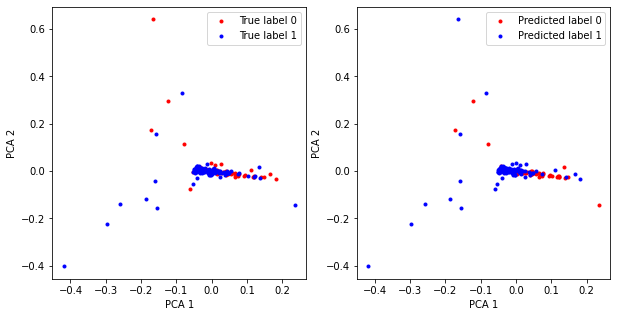

In [76]:
plt.figure(figsize=[10, 5])
plt.subplot(121)
plt.plot(pcaCom1[Ys==0], pcaCom2[Ys==0], "r.", label="True label 0")
plt.plot(pcaCom1[Ys==1], pcaCom2[Ys==1], "b.", label="True label 1")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()

# plt.subplot(132)
# plt.plot(pcaCom1[elabs==0], pcaCom2[elabs==0], "r.", label="Cluster label 0")
# plt.plot(pcaCom1[elabs==1], pcaCom2[elabs==1], "b.", label="Cluster label 1")
# plt.xlabel("PCA 1")
# plt.ylabel("PCA 2")
# plt.legend()

plt.subplot(122)
plt.plot(pcaCom1[eProbs1<=optThre], pcaCom2[eProbs1<=optThre], "r.", label="Predicted label 0")
plt.plot(pcaCom1[eProbs1>optThre], pcaCom2[eProbs1>optThre], "b.", label="Predicted label 1")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
#plt.savefig("./plots/rkNcptsCluster.jpg", bbox_inches='tight')

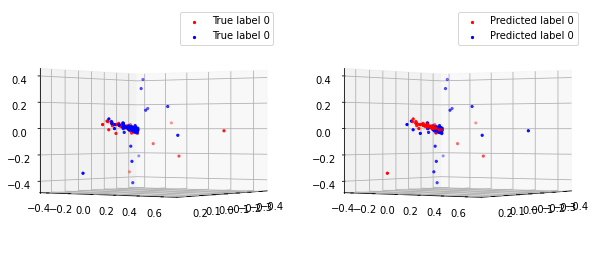

In [43]:
fig = plt.figure(figsize=[10, 5])
ax1 = fig.add_subplot(121, projection="3d")
ax1.scatter(pcaCom1[Ys==0], pcaCom2[Ys==0], pcaCom3[Ys==0], color="red", marker='.', label="True label 0")
ax1.scatter(pcaCom1[Ys==1], pcaCom2[Ys==1], pcaCom3[Ys==1], color="blue", marker='.', label="True label 0")
plt.legend()
#ax1.set_zlim([0, 1])

# ax2 = fig.add_subplot(132, projection="3d")
# ax2.scatter(pcaCom1[elabs==0], pcaCom2[elabs==0], pcaCom3[elabs==0], color="red", marker='.', label="Cluster label 0")
# ax2.scatter(pcaCom1[elabs==1], pcaCom2[elabs==1], pcaCom3[elabs==1], color="blue", marker='.', label="Cluster label 0")
# plt.legend()

ax3 = fig.add_subplot(122, projection="3d")
ax3.scatter(pcaCom1[eProbs1<=optThre], pcaCom2[eProbs1<=optThre], pcaCom3[eProbs1<=optThre], color="red", marker='.', label="Predicted label 0")
ax3.scatter(pcaCom1[eProbs1>optThre], pcaCom2[eProbs1>optThre], pcaCom3[eProbs1>optThre], color="blue", marker='.', label="Predicted label 0")
plt.legend()
ax1.view_init(0, 35)
ax3.view_init(0, 35)

### Test on eigvecs

In [35]:
import scipy
from prettytable import PrettyTable as pTB

In [36]:
import warnings
warnings.filterwarnings('ignore')

In [82]:
fswUAD = np.array([fs.maxwU for fs in fsAD])
fswUCtrl = np.array([fs.maxwU for fs in fsCtrl])

In [83]:
tts = []
rss = []
kss = []
for i in range(fswUAD.shape[1]):
    wUADcol = fswUAD[:, i]
    wUCtrlcol = fswUCtrl[:, i]
    tt = scipy.stats.ttest_ind(wUADcol, wUCtrlcol)
    rs = scipy.stats.ranksums(wUADcol, wUCtrlcol)
    ks = scipy.stats.kstest(wUADcol, wUCtrlcol)
    tts.append(tt.pvalue)
    rss.append(rs.pvalue)
    kss.append(ks.pvalue)

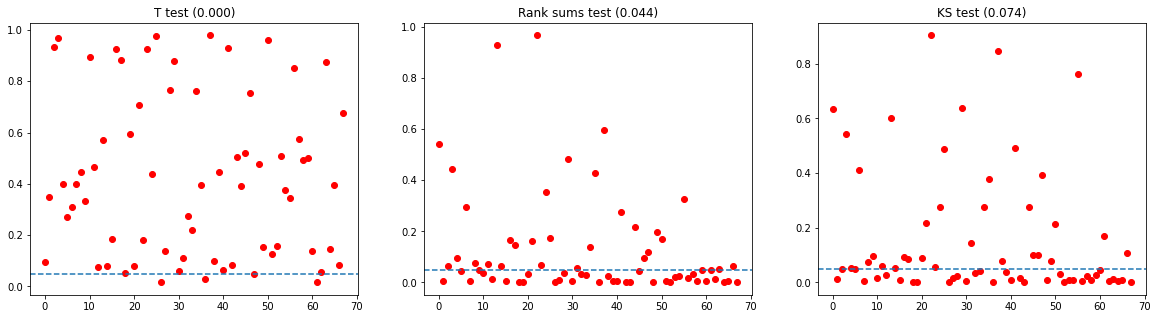

In [84]:
plt.figure(figsize=[20, 5])
plt.subplot(131)
prop = np.mean(np.array(tts) <= 0.05/68)
plt.title(f"T test ({prop:.3f})")
plt.plot(tts, "or")
plt.axhline(y=0.05, linestyle="--")

plt.subplot(132)
prop = np.mean(np.array(rss) <= 0.05/68)
plt.title(f"Rank sums test ({prop:.3f})")
plt.plot(rss, "or")
plt.axhline(y=0.05, linestyle="--")

plt.subplot(133)
prop = np.mean(np.array(kss) <= 0.05/68)
plt.title(f"KS test ({prop:.3f})")
plt.plot(kss, "or")
plt.axhline(y=0.05, linestyle="--")

In [101]:
def nlogMinMax(pvs):
    nlogpvs = -np.log(np.array(pvs))
    mmRes = np.zeros_like(nlogpvs)
    mmRes[:34] = (nlogpvs[:34] - np.min(nlogpvs[:34]))/(np.max(nlogpvs[:34]) - np.min(nlogpvs[:34]))
    mmRes[34:] = (nlogpvs[34:] - np.min(nlogpvs[34:]))/(np.max(nlogpvs[34:]) - np.min(nlogpvs[34:]))
    return mmRes


In [87]:
outTTS = U2BrainVec(reorderU(nlogMinMax(tts)))
outRSS = U2BrainVec(reorderU(nlogMinMax(rss)))
outKSS = U2BrainVec(reorderU(nlogMinMax(kss)))
np.savetxt("pvsPlotTtest.txt", outTTS)
np.savetxt("pvsPlotRStest.txt", outRSS)
np.savetxt("pvsPlotKStest.txt", outKSS)

In [31]:
np.where(np.array(rss) <= 0.05/68)

(array([19, 26, 36]),)

### Test on var of eigen values

In [37]:
fsEigValVarAbsAD = np.array([fs.eigValVarAbs for fs in fsAD])
fsEigValVarAbsCtrl = np.array([fs.eigValVarAbs for fs in fsCtrl])
fsEigValVarAD = np.array([fs.eigValVar for fs in fsAD])
fsEigValVarCtrl = np.array([fs.eigValVar for fs in fsCtrl])

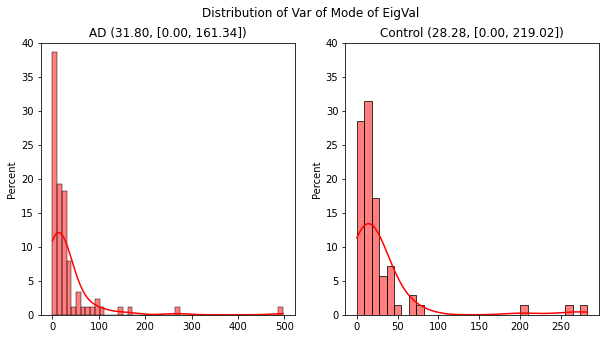

In [39]:
import seaborn as sns
plt.figure(figsize=[10, 5])
plt.suptitle("Distribution of Var of Mode of EigVal")
plt.subplot(121)
plt.title(f"AD ({np.mean(fsEigValVarAbsAD):.2f}, [{np.quantile(fsEigValVarAbsAD, 0.025):.2f}, {np.quantile(fsEigValVarAbsAD, 0.975):.2f}])")
sns.histplot(fsEigValVarAbsAD, stat="percent", kde=1, color="red")
plt.xlabel("")
plt.ylim([0, 40])

plt.subplot(122)
plt.title(f"Control ({np.mean(fsEigValVarAbsCtrl):.2f}, [{np.quantile(fsEigValVarAbsCtrl, 0.025):.2f}, {np.quantile(fsEigValVarAbsCtrl, 0.975):.2f}])")
sns.histplot(fsEigValVarAbsCtrl, stat="percent", kde=1, color="red")
plt.ylim([0, 40])
plt.xlabel("")

plt.savefig("./plots/dist_eigValVarAbs.jpg", bbox_inches='tight')

In [40]:
restt = scipy.stats.ttest_ind(fsEigValVarAbsAD, fsEigValVarAbsCtrl)
resrs = scipy.stats.ranksums(fsEigValVarAbsAD, fsEigValVarAbsCtrl)
resks = scipy.stats.kstest(fsEigValVarAbsAD, fsEigValVarAbsCtrl)
print(
    f"The pvalue of t test is {restt.pvalue:.4f}, "
    f"The pvalue of rank sum test is {resrs.pvalue:.4f}, "
    f"The pvalue of ks test is {resks.pvalue:.4f}."
     )

The pvalue of t test is 0.7079, The pvalue of rank sum test is 0.7714, The pvalue of ks test is 0.7138.


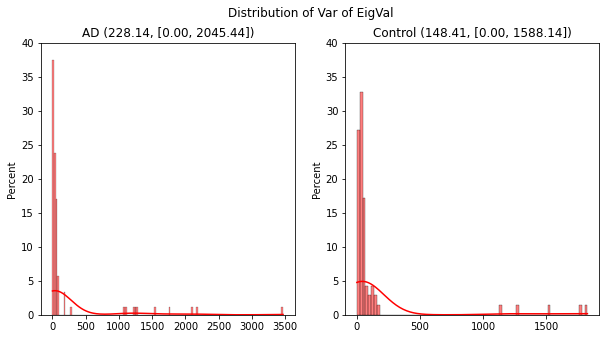

In [41]:
import seaborn as sns
plt.figure(figsize=[10, 5])
plt.suptitle("Distribution of Var of EigVal")
plt.subplot(121)
plt.title(f"AD ({np.mean(fsEigValVarAD):.2f}, [{np.quantile(fsEigValVarAD, 0.025):.2f}, {np.quantile(fsEigValVarAD, 0.975):.2f}])")
sns.histplot(fsEigValVarAD, stat="percent", kde=1, color="red")
plt.xlabel("")
plt.ylim([0, 40])

plt.subplot(122)
plt.title(f"Control ({np.mean(fsEigValVarCtrl):.2f}, [{np.quantile(fsEigValVarCtrl, 0.025):.2f}, {np.quantile(fsEigValVarCtrl, 0.975):.2f}])")
sns.histplot(fsEigValVarCtrl, stat="percent", kde=1, color="red")
plt.ylim([0, 40])
plt.xlabel("")

plt.savefig("./plots/dist_eigValVar.jpg", bbox_inches='tight')

In [42]:
restt = scipy.stats.ttest_ind(fsEigValVarAD, fsEigValVarCtrl)
resrs = scipy.stats.ranksums(fsEigValVarAD, fsEigValVarCtrl)
resks = scipy.stats.kstest(fsEigValVarAD, fsEigValVarCtrl)
print(
    f"The pvalue of t test is {restt.pvalue:.4f}, "
    f"The pvalue of rank sum test is {resrs.pvalue:.4f}, "
    f"The pvalue of ks test is {resks.pvalue:.4f}."
     )

The pvalue of t test is 0.3257, The pvalue of rank sum test is 0.4774, The pvalue of ks test is 0.3492.


### Corrs 

In [62]:
corrswUAD = np.array([fs.maxwUcorrs for fs in fsAD])
corrswUCtrl = np.array([fs.maxwUcorrs for fs in fsCtrl])
corrsUAD = np.array([fs.maxUcorrs for fs in fsAD])
corrsUCtrl = np.array([fs.maxUcorrs for fs in fsCtrl])

Text(0.5,0,'')

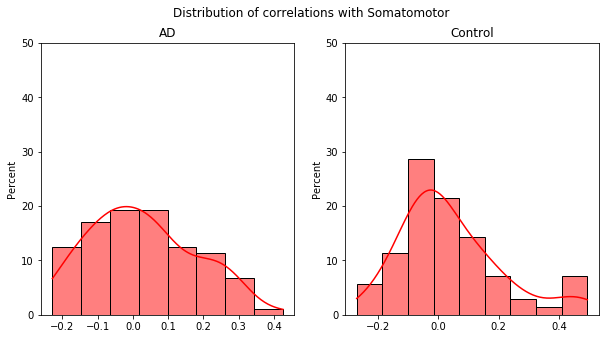

In [63]:
import seaborn as sns
idx = 4
plt.figure(figsize=[10, 5])
plt.suptitle(f"Distribution of correlations with {rowNames[idx]}")
plt.subplot(121)
plt.title("AD")
sns.histplot(corrswUAD[:, idx], stat="percent", kde=1, color="red")
plt.xlabel("")
plt.ylim([0, 50])

plt.subplot(122)
plt.title("Control")
sns.histplot(corrswUCtrl[:, idx], stat="percent", kde=1, color="red")
plt.ylim([0, 50])
plt.xlabel("")

#plt.savefig("./dist_ranks.jpg", bbox_inches='tight')

Text(0.5,0,'')

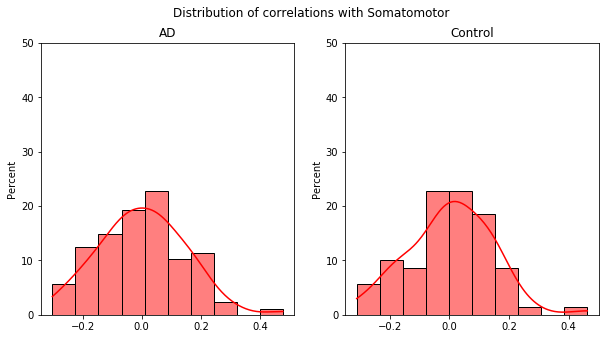

In [64]:
import seaborn as sns
idx = 4
plt.figure(figsize=[10, 5])
plt.suptitle(f"Distribution of correlations with {rowNames[idx]}")
plt.subplot(121)
plt.title("AD")
sns.histplot(corrsUAD[:, idx], stat="percent", kde=1, color="red")
plt.xlabel("")
plt.ylim([0, 50])

plt.subplot(122)
plt.title("Control")
sns.histplot(corrsUCtrl[:, idx], stat="percent", kde=1, color="red")
plt.ylim([0, 50])
plt.xlabel("")

#plt.savefig("./dist_ranks.jpg", bbox_inches='tight')

In [65]:
from prettytable import PrettyTable as pTB
tb = pTB()
tb.field_names = [" ", *rowNames]
testFns = {}
testFns["T test"] = ss.ttest_ind
testFns["Rank sums"] = ss.ranksums
testFns["KS test"] = ss.kstest
for key, testFn in testFns.items():
    pvs = []
    for idx, rowNam in enumerate(rowNames):
        curAD = corrsUAD[:, idx]
        curCtrl = corrsUCtrl[:, idx]
        resCur  = testFn(curAD, curCtrl)
        pvs.append(resCur.pvalue)
    tb.add_row([key, *pvs])
        

tb.float_format = ".4"
print(tb)

+-----------+---------+------------------+----------------+--------+-------------+-------------------+--------+
|           | Default | Dorsal_Attention | Frontoparietal | Limbic | Somatomotor | Ventral_Attention | Visual |
+-----------+---------+------------------+----------------+--------+-------------+-------------------+--------+
|   T test  |  0.1472 |      0.5418      |     0.3302     | 0.0160 |    0.9979   |       0.3762      | 0.0032 |
| Rank sums |  0.2313 |      0.5636      |     0.2612     | 0.0225 |    0.9442   |       0.3101      | 0.0039 |
|  KS test  |  0.3846 |      0.6070      |     0.5446     | 0.1288 |    0.8295   |       0.3409      | 0.0048 |
+-----------+---------+------------------+----------------+--------+-------------+-------------------+--------+


In [66]:
from prettytable import PrettyTable as pTB
tb = pTB()
tb.field_names = [" ", *rowNames]
testFns = {}
testFns["T test"] = ss.ttest_ind
testFns["Rank sums"] = ss.ranksums
testFns["KS test"] = ss.kstest
for key, testFn in testFns.items():
    pvs = []
    for idx, rowNam in enumerate(rowNames):
        curAD = corrswUAD[:, idx]
        curCtrl = corrswUCtrl[:, idx]
        resCur  = testFn(curAD, curCtrl)
        pvs.append(resCur.pvalue)
    tb.add_row([key, *pvs])
        

tb.float_format = ".4"
print(tb)

+-----------+---------+------------------+----------------+--------+-------------+-------------------+--------+
|           | Default | Dorsal_Attention | Frontoparietal | Limbic | Somatomotor | Ventral_Attention | Visual |
+-----------+---------+------------------+----------------+--------+-------------+-------------------+--------+
|   T test  |  0.1672 |      0.4650      |     0.1449     | 0.2518 |    0.6465   |       0.7614      | 0.0488 |
| Rank sums |  0.2466 |      0.4496      |     0.1051     | 0.2064 |    0.8583   |       0.6719      | 0.0231 |
|  KS test  |  0.5338 |      0.4361      |     0.3409     | 0.2200 |    0.8703   |       0.6830      | 0.0175 |
+-----------+---------+------------------+----------------+--------+-------------+-------------------+--------+
